<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Zero-shot-learning" data-toc-modified-id="Zero-shot-learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Zero-shot learning</a></span></li><li><span><a href="#Construct-linear-map" data-toc-modified-id="Construct-linear-map-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Construct linear map</a></span><ul class="toc-item"><li><span><a href="#Procrustes" data-toc-modified-id="Procrustes-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Procrustes</a></span></li><li><span><a href="#Least-squares" data-toc-modified-id="Least-squares-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Least squares</a></span></li></ul></li><li><span><a href="#1k" data-toc-modified-id="1k-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>1k</a></span><ul class="toc-item"><li><span><a href="#Describe-visual-dimensions" data-toc-modified-id="Describe-visual-dimensions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Describe visual dimensions</a></span></li><li><span><a href="#Word-embeddings" data-toc-modified-id="Word-embeddings-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Word embeddings</a></span></li><li><span><a href="#Theory" data-toc-modified-id="Theory-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Theory</a></span></li></ul></li><li><span><a href="#21k" data-toc-modified-id="21k-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>21k</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Compute-error" data-toc-modified-id="Compute-error-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Compute error</a></span></li></ul></li><li><span><a href="#Load-errors" data-toc-modified-id="Load-errors-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load errors</a></span></li><li><span><a href="#zero-shot-vs-one-shot" data-toc-modified-id="zero-shot-vs-one-shot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>zero-shot vs one-shot</a></span><ul class="toc-item"><li><span><a href="#Generalization-error" data-toc-modified-id="Generalization-error-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Generalization error</a></span></li><li><span><a href="#Distance-to-centroid" data-toc-modified-id="Distance-to-centroid-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Distance to centroid</a></span></li><li><span><a href="#Signal-noise-overlaps" data-toc-modified-id="Signal-noise-overlaps-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Signal-noise overlaps</a></span></li></ul></li><li><span><a href="#Project-manifolds" data-toc-modified-id="Project-manifolds-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Project manifolds</a></span></li></ul></div>

# Zero-shot learning

In [43]:
import numpy as np
from matplotlib import pyplot as plt
# from tqdm.notebook import tqdm
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

sns.set_style('darkgrid')
sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

In [44]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# Construct linear map

In [45]:
import torch
from torchnlp.word_to_vector import FastText, GloVe, CharNGram

wordvecs = GloVe(cache='/mnt/fs2/bsorsch/manifold/GloVe', dim=300)
# wordvecs = FastText(cache='/mnt/fs2/bsorsch/manifold/FastText/')

In [46]:
import os
root = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'
model = 'resnet50'
save_dir = os.path.join(root, model+'/')
centers = np.load(save_dir + 'centers.npy')
manifolds = np.load(save_dir + 'manifolds.npy',allow_pickle=True)
root_paths = np.load(root + 'root_paths_1k.npy',allow_pickle=True)
names = np.array([rp[0] for rp in root_paths])

ilsvrc_root = '/mnt/fs2/bsorsch/manifold/embeddings/ILSVRC/'
model = 'resnet50'
save_dir = os.path.join(ilsvrc_root, model+'/')
centers_1k = np.load(save_dir + 'centers.npy')
manifolds_1k = np.load(save_dir + 'manifolds.npy')
root_paths_1k = np.load('../manifold_old/data/ILSVRC_root_paths.npy',allow_pickle=True)

In [47]:
# Include only first name
wvs = []
wvs_all = []
embedding_idx = []
for i,rp in enumerate(root_paths[:1000]):
    wv = []
    name = rp[0]
    parts = name.split(', ')
    for part in parts:
        subparts = part.split(' ')
        for subpart in subparts:
            subsubparts = subpart.split('-')
            for subsubpart in subsubparts:
                # Remove apostrophes
                subsubpart = subsubpart.split("'")[0]
                wvtmp = wordvecs[subsubpart.lower()].numpy()
                if np.any(wvtmp!=0):
                    wv.append(wvtmp)  
    if wv:
        embedding_idx.append(i)
    else:
        wv = [np.nan*np.ones(300)]
    wvs.append(np.stack(wv).mean(0))
    wvs_all.append(np.stack(wv))
wvs = np.stack(wvs)
embedding_idx = np.stack(embedding_idx)
# wvs = wvs[embedding_idx]

In [48]:
# Include only first name
wvs_1k = []
embedding_idx_1k = []
for i,rp in enumerate(root_paths_1k):
    wv = []
    name = rp[0]
    parts = name.split(', ')
    for part in parts:
        subparts = part.split(' ')
        for subpart in subparts:
            subsubparts = subpart.split('-')
            for subsubpart in subsubparts:
                # Remove apostrophes
                subsubpart = subsubpart.split("'")[0]
                wvtmp = wordvecs[subsubpart.lower()].numpy()
                if np.any(wvtmp!=0):
                    wv.append(wvtmp)    
    if wv:
        embedding_idx_1k.append(i)
    else:
        wv = [np.nan*np.ones(300)]
    wvs_1k.append(np.stack(wv).mean(0))
wvs_1k = np.stack(wvs_1k)
embedding_idx_1k = np.stack(embedding_idx_1k)
# wvs_1k = wvs_1k[embedding_idx_1k]                   # keep only wvs with an embedding

In [49]:
wvs = wvs[embedding_idx]
centers = centers[embedding_idx]

In [50]:
wvs_1k = wvs_1k[embedding_idx_1k]
centers_1k = centers_1k[embedding_idx_1k]

In [51]:
# Normalize word vectors
WVMEAN = wvs_1k.mean(0)

wvs -= WVMEAN
wvs_1k -= WVMEAN
wvs /= np.linalg.norm(wvs, axis=-1,keepdims=True)
wvs_1k /= np.linalg.norm(wvs_1k, axis=-1,keepdims=True)
wvs = np.nan_to_num(wvs)
wvs_1k = np.nan_to_num(wvs_1k)

In [10]:
# # Normalize manifolds
# manifolds_norm = manifolds / np.linalg.norm(manifolds, axis=-1,keepdims=True)
# manifolds_1k_norm = manifolds_1k / np.linalg.norm(manifolds_1k, axis=-1,keepdims=True)
# centers_norm = manifolds_norm.mean(1)
# centers_1k_norm = manifolds_1k_norm.mean(1)

## Procrustes

In [52]:
def procrustes(X,Y):
    bx = X.mean(0)
    by = Y.mean(0)

    ax = 1/np.sqrt(np.sum((X - bx)**2))
    ay = 1/np.sqrt(np.sum((Y - by)**2))

    Xprime = ax*(X - bx)
    Yprime = ay*(Y - by)

    U,S,Vh = np.linalg.svd(Xprime.T@Yprime,full_matrices=False)

    O = U@Vh
    Yhat = Xprime@O / ay + by

    overlap = (Yhat*Y).sum() / np.sqrt(np.sum(Yhat**2))/ np.sqrt(np.sum(Y**2))

    return ax,ay,bx,by,O,overlap


def map_procrustes(X,ax,ay,bx,by,O):
    return ax/ay*(X-bx)@O + by

In [53]:
ax,ay,bx,by,O,overlap = procrustes(wvs_1k,centers_1k)

## Least squares

In [54]:
def least_squares(Xtrain,Xtest,Ytrain,Ytest):
    n_classes = len(Xtrain)
    M = wvs.shape[-1]

    A = np.concatenate([Xtrain,np.ones((n_classes,1))],axis=1)
    x = np.linalg.pinv(A.T@A+1e1)@A.T@Ytrain
    W = x[:M]
    b = x[-1]

    # Residuals
    resid_1k = np.linalg.norm(Xtrain@W + b - Ytrain, axis=-1)
    cos_ang_1k = ((Xtrain@W + b)*Ytrain).sum(-1)
    cos_ang_1k /= np.linalg.norm(Xtrain@W + b,axis=-1) * np.linalg.norm(Ytrain, axis=-1)
    
    resid = np.linalg.norm(Xtest@W + b - Ytest, axis=-1)
    cos_ang = ((Xtest@W + b)*Ytest).sum(-1)
    cos_ang /= np.linalg.norm(Xtest@W + b,axis=-1) * np.linalg.norm(Ytest, axis=-1)
    
    return W, b, resid, resid_1k, cos_ang, cos_ang_1k

# 1k

In [55]:
import numpy as np

In [56]:
manifolds_load = np.copy(manifolds)[embedding_idx]

In [57]:
P = 500
manifolds = []
for manifold in manifolds_load:
    manifolds.append(manifold[:P])
manifolds = np.stack(manifolds)

In [58]:
from jax import numpy as np
from jax import jit

In [59]:
manifolds = np.array(manifolds)

In [60]:
@jit
def zero_shot(y1,y2,manifold):
    w = (y1 - y2)
    mu = (y1 + y2) / 2
    h = w@manifold.T - w@mu
    err = (h < 0).mean()
    return err

@jit
def map_procrustes_fast(X,ax,ay,bx,by,O):
    return ax/ay*(X-bx)@O + by

In [61]:
zse = []
zse_ls = []
n_classes = len(manifolds)
for a in tqdm(range(n_classes)):
    manifold = manifolds[a]
    y1 = map_procrustes_fast(wvs[a],ax,ay,bx,by,O)
#     y1_ls = wvs[i]@W + b
    for b in range(n_classes):
        if a!=b:
            y2 = map_procrustes_fast(wvs[b],ax,ay,bx,by,O)
#             y2_ls = wvs[j]@W + b
            zse.append(zero_shot(y1,y2,manifold))
#             zse_ls.append(zero_shot(y1_ls,y2_ls,manifold))

zse = np.stack(zse).reshape(n_classes,n_classes-1)
# zse_ls = np.stack(zse_ls).reshape(n_classes,n_classes-1)

In [19]:
mask = np.eye(988,dtype='bool')
1-np.mean(zse[~mask])

DeviceArray(0.93404686, dtype=float32)

In [26]:
mask = np.eye(988,dtype='bool')
1-np.mean(zse[~mask])

DeviceArray(0.97712606, dtype=float32)

In [72]:
mask = np.eye(988,dtype='bool')
1-np.mean(zse[~mask])

DeviceArray(0.9342785, dtype=float32)

In [29]:
zse_new = zse

In [ ]:
import numpy as npo
print('Accuracy: {:.3f}%'.format(100*(1-npo.nanmean(zse))))
plt.hist(zse.ravel(), bins=30);

In [14]:
root = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'
save_dir = os.path.join(root, model+'/')
zse = np.load(os.path.join(save_dir,'zero_shot_err_1k.npy'))

In [15]:
from utils import make_square

In [16]:
zse = make_square(zse)

In [22]:
# root = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'
# save_dir = os.path.join(root, model+'/')
# np.save(os.path.join(save_dir,'zero_shot_err_1k.npy'),zse)

In [23]:
wtex = wordvecs['salad']
ytex = map_procrustes_fast(wtex.numpy(),ax,ay,bx,by,O)
sim = centers@ytex / np.linalg.norm(centers,axis=-1)

for i in range(10):
    print(names[embedding_idx][np.argsort(-sim)[i]])

green salad
schnitzel, Wiener schnitzel
eggs Benedict
open-face sandwich, open sandwich
chow, chuck, eats, grub
coleslaw, slaw
stuffed peppers
scrambled eggs
hollandaise
special


In [150]:
names_1k = [rp[0] for rp in root_paths_1k]

In [91]:
wnid_from_class(names[0])

'n02461128'

In [20]:
[name for name in names if 'Texas' in name]

['Texas bluebonnet, Lupinus texensis',
 'bluebonnet, buffalo clover, Texas bluebonnet, Lupinus subcarnosus']

In [147]:
[name for name in names if 'cactus' in name]

['Christmas cactus, Schlumbergera buckleyi, Schlumbergera baridgesii',
 'barrel cactus',
 'hedgehog cactus']

In [22]:
i1 = np.where(names[embedding_idx]=='Texas bluebonnet, Lupinus texensis')[0][0]
print(i1)

19


In [72]:
i2 = np.where(names[embedding_idx]=='African daisy')[0][0]
print(i2)

515


In [63]:
i3 = np.where(names[embedding_idx]=='green salad')[0][0]
print(i3)

649


In [73]:
1-zse[i1,i2]

0.3199999928474426

In [74]:
import numpy as np

In [82]:
y1.shape

torch.Size([2048])

In [85]:
tex_projex = centers@y1.numpy() / np.linalg.norm(centers,axis=-1)

In [119]:
y1.shape

torch.Size([2048])

In [123]:
from scipy.spatial.distance import cdist
tex_dist = cdist(centers,y1.numpy()[None]).squeeze()

In [125]:
names[embedding_idx][np.argsort(tex_dist)]

array(['sausage dog, sausage hound', 'ball',
       'bluebonnet, buffalo clover, Texas bluebonnet, Lupinus subcarnosus',
       'paddy', 'Texas bluebonnet, Lupinus texensis', 'Frisbee',
       'tallgrass, tall-grass', 'field', 'cue ball',
       'leash, tether, lead', 'stray',
       'prairie gentian, tulip gentian, bluebell, Eustoma grandiflorum',
       'red currant', 'redberry, red-berry, Rhamnus croceus',
       'blacktop, blacktopping', 'bowling ball, bowl',
       'mustachio, moustachio, handle-bars',
       'corn poppy, field poppy, Flanders poppy, Papaver rhoeas', 'floor',
       "comforter, pacifier, baby's dummy, teething ring", 'raspberry',
       'water dog', 'Tulipa gesneriana',
       "purple heather, Brewer's mountain heather, Phyllodoce breweri",
       'Easter egg', 'parquet, parquet floor', 'cranberry sauce',
       'juniper berries', 'Pyracantha, pyracanth, fire thorn, firethorn',
       'mountain ash, Fraxinus texensis', 'mulch',
       'fireweed, Erechtites hieraci

In [110]:
from PIL import Image
from utils import wnid_from_class, concat_images_in_rows
imdir = '/mnt/fs0/datasets/ImageNet21k/'

def plot_many(names_toplot):
    nrows=len(names_toplot)//5
    imgs = []
    for name in names_toplot:
        try:
            wnid = wnid_from_class(name)
            class_path = os.path.join(imdir,wnid)
            impaths = os.listdir(class_path)
            im = Image.open(class_path+'/'+impaths[0])
            im = np.array(im.resize((224,224)))
            assert im.shape==(224,224,3)
            imgs.append(im)
        except:
            pass
    
    imgs = np.stack(imgs)
    implot = concat_images_in_rows(imgs,nrows)
    
    plt.figure(figsize=(15,3*nrows))
    plt.imshow(implot)
    plt.axis('off')

In [143]:
(wordvecs['texas']**2).sum()

tensor(53.2348)

In [179]:
# Find names that share a word:
duplicates1 = []
duplicates2 = []
for name in names:
    words = name.split(',')
    for word in words:
        for name2 in names:
            if word in name2 and name!=name2:
                duplicates1.append(name)
                duplicates2.append(name2)

In [ ]:
for i in range(100,150):
    print(duplicates1[i] + ' vs ' + duplicates2[i])

In [383]:
i1 = np.where(names[embedding_idx]=='steering wheel, wheel')[0][0]
print(i1)

309


In [384]:
i2 = np.where(names[embedding_idx]=='Ferris wheel')[0][0]
print(i2)

244


In [385]:
i3 = np.where(names[embedding_idx]=='bicycle wheel')[0][0]
print(i3)

270


In [386]:
word1='steering'
word2 = 'ferris'
word3 = 'bicycle'

y1 = map_procrustes(wordvecs[word1],ax,ay,bx,by,O)
y2 = map_procrustes(wordvecs[word2],ax,ay,bx,by,O)
y3 = map_procrustes(wordvecs[word3],ax,ay,bx,by,O)

In [387]:
y = np.stack([y1,y2,y3])

In [388]:
c1 = y@manifolds[embedding_idx[i1]].T
c2 = y@manifolds[embedding_idx[i2]].T
c3 = y@manifolds[embedding_idx[i3]].T

In [393]:
c1 = y@manifolds[i1].T
c2 = y@manifolds[i2].T
c3 = y@manifolds[i3].T

In [394]:
y01 = map_procrustes(wvs[i1],ax,ay,bx,by,O)
y02 = map_procrustes(wvs[i2],ax,ay,bx,by,O)
y03 = map_procrustes(wvs[i3],ax,ay,bx,by,O)

In [395]:
c01 = y@y01
c02 = y@y02
c03 = y@y03

In [396]:
w1 = c01 - c02
b1 = w1@(c01+c02)/2
def z1(x):
    return (b1 - w1[0]*x)/w1[1]

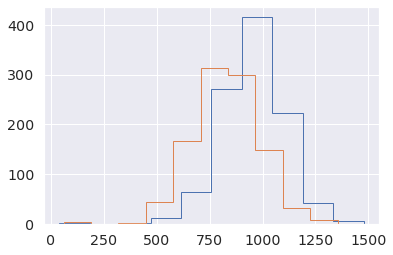

In [409]:
plt.hist(c2[1], histtype='step')
plt.hist(c3[1], histtype='step');

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))

plt.scatter(c1[0],c1[1],label='barrel cactus')
plt.scatter(c2[0],c2[1],label='hedgehog cactus')
plt.axis('equal')

# plt.scatter(c01[0],c01[1],label='Texas bluebonnet')
# plt.scatter(c02[0],c02[1],label='African daisy')

plt.xlabel(r'$y_{barrel}$')
plt.ylabel(r'$y_{hedgehog}$')


xx = np.linspace(-100,1200,10)
plt.plot(xx,z(xx))

In [444]:
ys_all.shape

(10000, 2048)

In [460]:
y = map_procrustes(wordvecs['texas'],ax,ay,bx,by,O)

In [461]:
centers.shape

(988, 2048)

In [465]:
texdist_all = cdist(y[None],ys_all,metric='cosine').squeeze()

ii = np.argsort(texdist_all)
for i in ii[:200]:
    print(wordvecs.index_to_token[i])

texas
florida
california
york
american
canada
poker
county
uk
Texas
las
united
insurance
christmas
st
london
indian
gambling
casino
los
auto
lake
springs
jack
west
south
mortgage
university
payday
india
jersey
n`t
north
college
valley
betting
state
url
golf
casinos
free
www
online
j
facts
park
china
estate
palm
cash
dealer
asian
corporation
homepage
dating
don
hall
hill
association
french
ma
loan
dvd
english
southern
nude
nursing
bank
clubs
Arkansas
club
dog
city
real
tattoo
grand
dealers
employment
truck
loans
law
school
sale
laws
tv
consolidation
horse
rental
adult
attorney
rentals
cards
pharmacy
liberty
sex
wholesale
bay
credit
western
hunt
turkey
pet
hold
hunting
motorcycle
internet
baseball
TX
whats
football
rules
broker
fair
fuck
em
counseling
mac
east
Searches
automobile
national
tournament
basketball
bet
education
medical
royal
advance
oh
ll
elementary
hi
animal
xxx
pre
states
dental
i
chase
cd
clinic
center
depends
river
teen
blind
com
car
big
license
antique
homes
torrent
gay

In [466]:
wv1 = wordvecs['bluebonnet']
wv2 = wordvecs['texas']

print(((wv1*wv2)).sum()/np.linalg.norm(wv1)/np.linalg.norm(wv2))

tensor(0.2901)


In [476]:
np.linalg.norm(wvb)

7.0197816

In [477]:
len(wordvecs)

2196017

In [488]:
len(wordvecs)

2196017

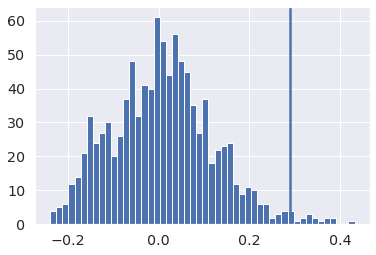

In [498]:
idxs = np.random.randint(0,len(wordvecs),10000)
wv1 = wordvecs['cactus']
wvb = wordvecs['h']
wv2 = wvs_1k

plt.hist(((wv1*wv2)).sum(-1)/np.linalg.norm(wv1)/np.linalg.norm(wv2,axis=-1), bins=50);
plt.axvline(((wv1*wvb)).sum()/np.linalg.norm(wv1)/np.linalg.norm(wvb))

In [500]:
((wv1-wv2)**2).sum(-1).shape

torch.Size([994])

In [504]:
(wv1 - wv2)**2.shape

torch.Size([988, 300])

In [513]:
torch.min(((wv1-wv2)**2).sum(-1))

tensor(0.9539, dtype=torch.float64)

In [514]:
((wv1-wvb)**2).sum()

tensor(0.9198)

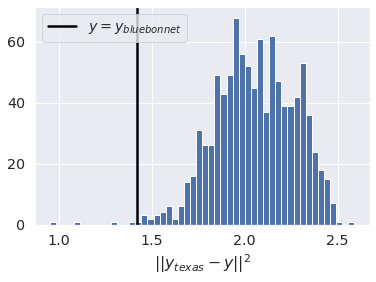

In [552]:
idxs = np.random.randint(0,len(wordvecs),10000)
wv1 = wordvecs['texas']
wv1 /= np.linalg.norm(wv1)
wvb = wordvecs['bluebonnet']
wvb /= np.linalg.norm(wvb)
wv2 = wvs

plt.hist(((wv1-wv2)**2).sum(-1), bins=50);
plt.axvline(((wv1-wvb)**2).sum(), c='black',label=r'$y=y_{bluebonnet}$')
plt.xlabel(r'$\||y_{texas} - y\||^2$')
plt.legend();

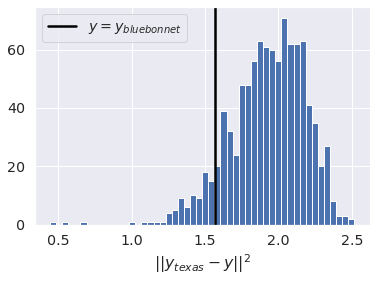

In [554]:
idxs = np.random.randint(0,len(wordvecs),10000)
wv1 = wordvecs['cactus']
wv1 /= np.linalg.norm(wv1)
wvb = wordvecs['barrel']
wvb /= np.linalg.norm(wvb)
wv2 = wvs

plt.hist(((wv1-wv2)**2).sum(-1), bins=50);
plt.axvline(((wv1-wvb)**2).sum(), c='black',label=r'$y=y_{bluebonnet}$')
plt.xlabel(r'$\||y_{texas} - y\||^2$')
plt.legend();

In [411]:
w1 = c01 - c02
b1 = w1@(c01+c02)/2
def z1(x,y):
    return (b1 - w1[0]*x - w1[1]*y)/w1[2]

w2 = c01 - c03
b2 = w2@(c01+c03)/2
def z2(x,y):
    return (b2 - w2[0]*x - w2[1]*y)/w2[2]

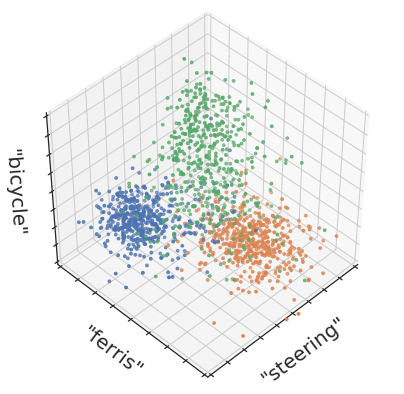

In [402]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')

ax1.scatter(c1[0],c1[1],c1[2],label=word1, s=8)
ax1.scatter(c2[0],c2[1],c2[2],label=word2, s=8)
ax1.scatter(c3[0],c3[1],c3[2],label=word3, s=8)
ax1.view_init(45,45)
# plt.legend(loc=2)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.zaxis.set_ticklabels([])

ax1.set_xlabel('"{}"'.format(word1),fontsize=20)
ax1.set_ylabel('"{}"'.format(word2),fontsize=20)
ax1.set_zlabel('"{}"'.format(word3),fontsize=20)

ax1.set_xlim(0,900)
ax1.set_ylim(0,800)
ax1.set_zlim(0,800)


# xx = np.linspace(-100,1200,10)
# x,y = np.meshgrid(xx,xx)
# ax1.plot_surface(x, y, z1(x,y),alpha=0.1)
# ax1.plot_surface(x, y, z2(x,y),alpha=0.1)
plt.savefig('images/steering_ferris_bicycle.pdf')

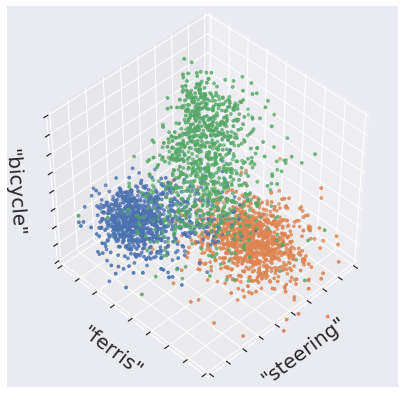

In [550]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')

ax1.scatter(c1[0],c1[1],c1[2],label=word1, s=8)
ax1.scatter(c2[0],c2[1],c2[2],label=word2, s=8)
ax1.scatter(c3[0],c3[1],c3[2],label=word3, s=8)
ax1.view_init(45,45)
# plt.legend(loc=2)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.zaxis.set_ticklabels([])

ax1.set_xlabel('"{}"'.format(word1),fontsize=20)
ax1.set_ylabel('"{}"'.format(word2),fontsize=20)
ax1.set_zlabel('"{}"'.format(word3),fontsize=20)

ax1.set_xlim(0,900)
ax1.set_ylim(0,800)
ax1.set_zlim(0,800)


# xx = np.linspace(-100,1200,10)
# x,y = np.meshgrid(xx,xx)
# ax1.plot_surface(x, y, z1(x,y),alpha=0.1)
# ax1.plot_surface(x, y, z2(x,y),alpha=0.1)
# plt.savefig('images/steering_ferris_bicycle.pdf')

In [612]:
names[np.argmax(zse[863])]

'field mustard, wild mustard, charlock, chadlock, Brassica kaber, Sinapis arvensis'

In [664]:
np.corrcoef(wordvecs['salad'],wordvecs['snake'])

array([[1.        , 0.23445915],
       [0.23445915, 1.        ]])

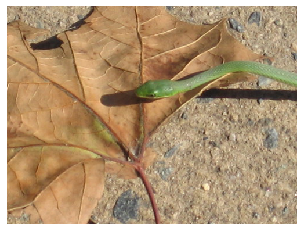

In [799]:
plot_single('green snake',7)

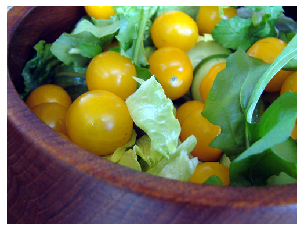

In [807]:
plot_single('green salad',1)

In [ ]:
wvs[]

In [599]:
len(wvs_all[863])

3

In [561]:
from PIL import Image
from utils import concat_images_in_rows

path = '/mnt/fs2/bsorsch/manifold/held_out_imagenet/'


def plot_single(name,idx):
    class_path = path + name
    impaths = os.listdir(class_path)
    im = Image.open(class_path+'/'+impaths[idx])
    plt.imshow(im)
    plt.axis('off')

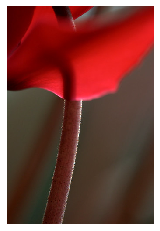

In [582]:
plot_single('cyclamen, Cyclamen purpurascens',0)

In [534]:
sim.shape

(988,)

In [525]:
# np.argsort(sim)[-1]a
len(np.unique(wvs[:,0]))

988

## Describe visual dimensions

In [91]:
U,S,V = np.linalg.svd(centers-centers.mean(0),full_matrices=False)

In [130]:
ys_all= []
for wv in tqdm(wordvecs.vectors[:10000]):
    y = map_procrustes(wv,ax,ay,bx,by,O)
    ys_all.append(y)

In [131]:
ys_all = np.stack(ys_all)

In [118]:
for j,v in enumerate(V[:10]):
    print('--Dimension {}--'.format(j))
    sim = ys_all@v / np.linalg.norm(ys_all,axis=-1)
    print('Most similar:')
    for i in range(5):
        print(' - ' + wordvecs.index_to_token[np.argsort(-sim)[i]])

    print('Most dissimilar:')
    for i in range(5):
        print(' - ' + wordvecs.index_to_token[np.argsort(sim)[i]])

--Dimension 0--
Most similar:
 - SCBA
 - Greubel
 - trolley
 - back-up
 - keg
Most dissimilar:
 - chrysanthemum
 - flowering
 - flower
 - blossoms
 - blooming
--Dimension 1--
Most similar:
 - sauce
 - butter
 - cheese
 - soup
 - pasta
Most dissimilar:
 - White-tailed
 - KeyAustralian
 - Egret
 - heron
 - Cranes
--Dimension 2--
Most similar:
 - oystercatcher
 - merganser
 - lapwing
 - curlew
 - grebe
Most dissimilar:
 - wall
 - walls
 - front
 - entrance
 - doors
--Dimension 3--
Most similar:
 - hillside
 - hilltop
 - overlooking
 - cliffs
 - mountainside
Most dissimilar:
 - matching
 - cuffs
 - purse
 - embroidery
 - cuff
--Dimension 4--
Most similar:
 - sandbar
 - beach
 - surf
 - fringed
 - waters
Most dissimilar:
 - belfry
 - cupola
 - belltower
 - Cupola
 - cathedral
--Dimension 5--
Most similar:
 - lizard
 - fossilized
 - basilisk
 - fossilised
 - lichen
Most dissimilar:
 - Aviation
 - aviation
 - aircraft
 - shuttle
 - onboard
--Dimension 6--
Most similar:
 - nightstand
 - damask

## Word embeddings

In [25]:
import numpy as np

In [26]:
zse = np.array(zse)

In [27]:
from utils import make_square
zse = make_square(zse)

In [28]:
from scipy.spatial.distance import pdist, squareform
wvpdist = squareform(pdist(wvs_all[0]))
wvdist = np.mean(wvpdist[wvpdist!=0])

In [55]:
wvpdist.shape

(1, 1)

In [427]:
i = 10
wv = wvs_all[i]
wvpdist = squareform(pdist(wvs_all[i]))
mask = np.eye(len(wvpdist),dtype='bool')
print(np.mean(wvpdist))
print(np.mean(wvpdist[~mask]))

0.5249777987563545
0.7874666981345317


In [265]:
wv.shape

(3, 300)

In [267]:
np.linalg.norm(wv-wv.mean(0),axis=-1)

array([0.39373335, 0.39373335, 0.7874667 ], dtype=float32)

In [217]:
wvpdist.shape

(3, 3)

In [218]:
np.tril(wvpdist)

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [1.18120005, 1.18120005, 0.        ]])

In [ ]:
wv

In [416]:
wvdists = []
for i in tqdm(embedding_idx):
    wv = wvs_all[i]
#     wv /= np.linalg.norm(wv,axis=-1,keepdims=True)
    wvdist = (np.linalg.norm(wv-wv.mean(0),axis=-1)**2).mean()
#     wvpdist = squareform(pdist(wvs_all[i]))
#     mask = np.eye(len(wvpdist),dtype='bool')
#     wvdist = np.mean(wvpdist[~mask])
    wvdists.append(wvdist)
wvdists = np.array(wvdists)

(array([268.,  22.,  58., 102., 131., 109., 126., 104.,  51.,  17.]),
 array([0.        , 0.07809491, 0.15618983, 0.23428476, 0.31237966,
        0.3904746 , 0.46856952, 0.5466644 , 0.6247593 , 0.7028543 ,
        0.7809492 ], dtype=float32),
 <a list of 10 Patch objects>)

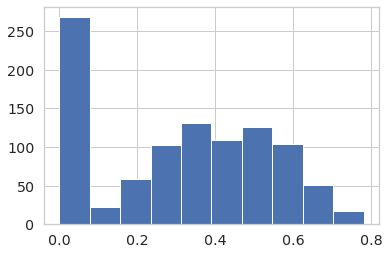

In [417]:
plt.hist(wvdists)

In [418]:
wvdistpair = np.minimum(wvdists[None],wvdists[:,None])
# wvdistpair = (wvdists[None]+wvdists[:,None])/2

In [454]:
x = np.nan_to_num(wvdistpair)
y = zse
mask = x!=0
np.corrcoef(x,y)

np.corrcoef(x[mask],y[mask])

array([[1.        , 0.07679987],
       [0.07679987, 1.        ]])

Text(0, 0.5, 'zero-shot error')

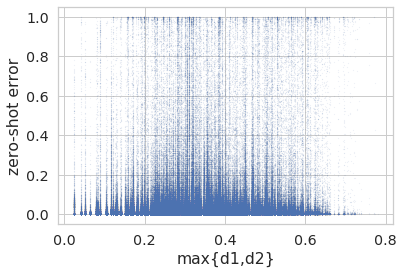

In [455]:
with sns.axes_style('whitegrid'):
    plt.scatter(x[mask],y[mask],s=0.001)
plt.xlabel('max{d1,d2}')
plt.ylabel('zero-shot error')

In [456]:
from scipy.stats import binned_statistic

In [459]:
binmean,bins,binnnum = binned_statistic(x.ravel(),y.ravel(),bins=20)
binstd,bins,binnnum = binned_statistic(x.ravel(),y.ravel(),bins=20,statistic='std')
counts,bins,binnnum = binned_statistic(x.ravel(),y.ravel(),bins=20,statistic='count')

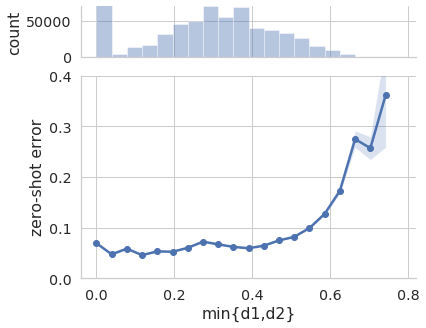

In [461]:
f, (ax_hist, ax_box) = plt.subplots(2, figsize=(6,5), sharex=True,
                                            gridspec_kw={"height_ratios": (.2, .8)})

ax_box.plot(bins[:-1],binmean,'o-')
ax_box.fill_between(bins[:-1],
                 binmean- binstd / np.sqrt(counts),
                 binmean+ binstd / np.sqrt(counts), alpha=0.2)
plt.ylabel('zero-shot error')
plt.xlabel('min{d1,d2}')
plt.ylim([0,0.4])

sns.distplot(x.ravel(),kde=False,bins=20,ax=ax_hist)
sns.despine()
ax_hist.set_ylabel('count')
ax_hist.set_ylim([0,70000])
plt.subplots_adjust(wspace=0, hspace=.15)

In [491]:
avgdists = []
for m in np.arange(1,100):
    X = np.random.randn(m,1000)
    X /= np.linalg.norm(X,axis=-1,keepdims=True)
    avgdist = ((X - X.mean(0))**2).sum(-1).mean()
    avgdists.append(avgdist)

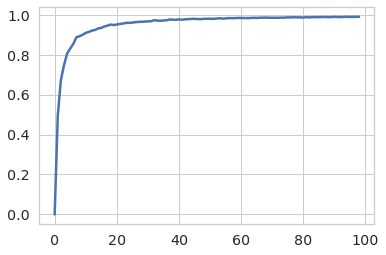

In [492]:
plt.plot(avgdists)

In [475]:
binmean,bins,binnnum = binned_statistic(wvdists,zse.mean(0),bins=20)
binstd,bins,binnnum = binned_statistic(wvdists,zse.mean(0),bins=20,statistic='std')
counts,bins,binnnum = binned_statistic(wvdists,zse.mean(0),bins=20,statistic='count')

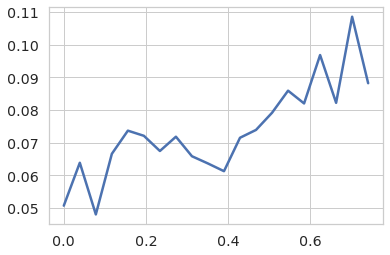

In [476]:
plt.plot(bins[:-1],binmean)

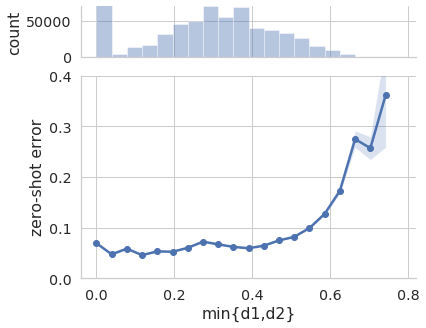

In [461]:
f, (ax_hist, ax_box) = plt.subplots(2, figsize=(6,5), sharex=True,
                                            gridspec_kw={"height_ratios": (.2, .8)})

ax_box.plot(bins[:-1],binmean,'o-')
ax_box.fill_between(bins[:-1],
                 binmean- binstd / np.sqrt(counts),
                 binmean+ binstd / np.sqrt(counts), alpha=0.2)
plt.ylabel('zero-shot error')
plt.xlabel('min{d1,d2}')
plt.ylim([0,0.4])

sns.distplot(x.ravel(),kde=False,bins=20,ax=ax_hist)
sns.despine()
ax_hist.set_ylabel('count')
ax_hist.set_ylim([0,70000])
plt.subplots_adjust(wspace=0, hspace=.15)

In [462]:
np.nanmean(1-y[x<0.5])

0.9346390573367608

In [465]:
K = len(embedding_idx)
i1,i2 = np.unravel_index(np.argsort(-x.ravel()),(K,K))

In [466]:
for i in range(1000,1020):
    print('{} vs {}'.format(names[embedding_idx][i1[i]],names[embedding_idx][i2[i]]))

bee balm, beebalm, bergamot mint, oswego tea, Monarda didyma vs mayapple, May apple, wild mandrake, Podophyllum peltatum
bee balm, beebalm, bergamot mint, oswego tea, Monarda didyma vs mourning cloak, mourning cloak butterfly, Camberwell beauty, Nymphalis antiopa
bee balm, beebalm, bergamot mint, oswego tea, Monarda didyma vs bleeding heart, lyreflower, lyre-flower, Dicentra spectabilis
bee balm, beebalm, bergamot mint, oswego tea, Monarda didyma vs moonflower, belle de nuit, Ipomoea alba
mayapple, May apple, wild mandrake, Podophyllum peltatum vs bee balm, beebalm, bergamot mint, oswego tea, Monarda didyma
bee balm, beebalm, bergamot mint, oswego tea, Monarda didyma vs tree swallow, tree martin, Hirundo nigricans
bee balm, beebalm, bergamot mint, oswego tea, Monarda didyma vs Indian pipe, waxflower, Monotropa uniflora
bee balm, beebalm, bergamot mint, oswego tea, Monarda didyma vs bird's-foot violet, pansy violet, Johnny-jump-up, wood violet, Viola pedata
red-hot poker, Kniphofia prae

(array([  5776.,  21375.,  61425., 141836., 110580.,  69615.,  73569.,
         32775.,   6825.,    400.]),
 array([0.15133945, 0.25363299, 0.35592653, 0.45822006, 0.5605136 ,
        0.66280714, 0.76510067, 0.86739421, 0.96968775, 1.07198128,
        1.17427482]),
 <a list of 10 Patch objects>)

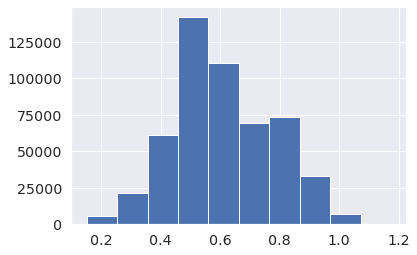

In [125]:
plt.hist(x[mask].ravel())

In [172]:
ts = np.linspace(0.5,1.7,100)

top_accs = []
bottom_accs = []
for t in ts:
    top_accs.append(1-np.mean(zse.ravel()[mask][np.where(x[mask]>t)]))
    bottom_accs.append(1-np.mean(zse.ravel()[mask][np.where(x[mask]<t)]))

/home/bsorsch/.torch3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bsorsch/.torch3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


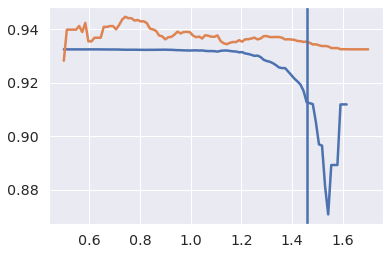

In [174]:
plt.plot(ts,top_accs)
plt.plot(ts,bottom_accs)
plt.axvline(1.46)

In [124]:
1-np.mean(zse.ravel()[np.where(x<1)])

0.9344453369631756

## Theory

In [6]:
root = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'
save_dir = os.path.join(root, model+'/')
zse = np.load(os.path.join(save_dir,'zero_shot_err_1k.npy'))

In [7]:
model_name = 'resnet50'
model_dir = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'+model_name+'/'

In [8]:
Us = np.load(os.path.join(model_dir, 'Us.npy'))
Rs = np.load(os.path.join(model_dir, 'Rs.npy'))

In [24]:
import numpy as np

In [27]:
ys = []
for wv in wvs:
    ys.append(map_procrustes_fast(wv,ax,ay,bx,by,O))
ys = np.stack(ys)

/home/bsorsch/.torch3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [28]:
Rs = Rs[embedding_idx]
Us = Us[embedding_idx]

In [29]:
K = len(wvs)
signal = []
css = []
for a in tqdm(range(K)):
    for b in range(K):
        dxy = -((ys[a] - centers[a])**2).sum() + ((ys[b] - centers[a])**2).sum()
        signal.append(dxy / (Rs[a]**2).mean())
        
        costheta = Us[a]@(ys[a] - ys[b])
        cs = (Rs[a]**2 * costheta**2).mean() / (Rs[a]**2).mean()**2
        css.append(cs)
css = np.stack(css).reshape(K,K)
signal = np.stack(signal).reshape(K,K)

In [30]:
from utils import make_square

In [31]:
from scipy.special import erfc

def H(x):
    return 1/2*erfc(x/np.sqrt(2))

In [32]:
SNR = signal/2/np.sqrt(css)

/home/bsorsch/.torch3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [33]:
from utils import make_square

In [34]:
names = [rp[0] for rp in root_paths]

In [36]:
SNR.shape

(988, 988)

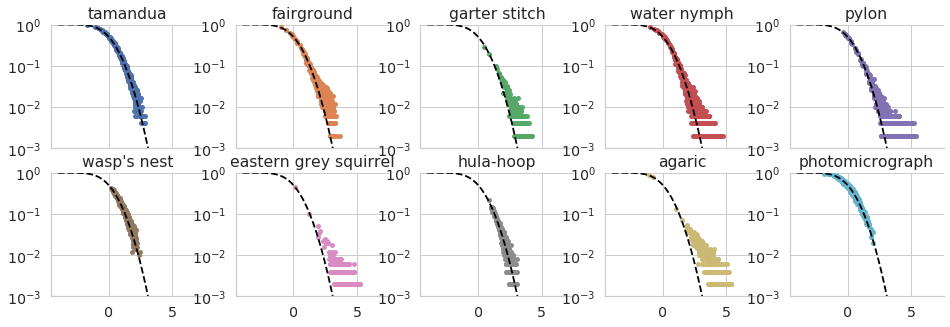

In [42]:
n_plots = 10
n_classes = 1000
with sns.axes_style('whitegrid'):    
    plt.figure(figsize=(16, n_plots//5*2.5))
    c = 0
    for i in range(n_plots):
        ax = plt.subplot(n_plots//5,5,i+1)
        plt.scatter(SNR[i],zse[i], c='C' + str(c%10), s=15)
        plt.title(names[i].split(',')[0])
        c+=1  # update color counter

        # Plot theory
#         x = np.linspace(np.nanmin(SNR[i]),np.nanmax(SNR[i])+1,50)
        x = np.linspace(-4,7,100)
        plt.plot(x, H(x), c='black', linestyle='dashed', linewidth=1.8, label='theory')
        if i <5:
            ax.set_xticklabels([])
#         plt.xlabel('SNR', fontsize=14)
#         if i%4==0:
#             plt.ylabel(r'$\epsilon_g$', fontsize=20)
#         if c==4:
#             plt.legend()
        sns.despine()
        plt.yscale('log')
        plt.ylim([1e-3,1])
# plt.tight_layout()
# plt.savefig('images/zero_shot_errs.pdf')

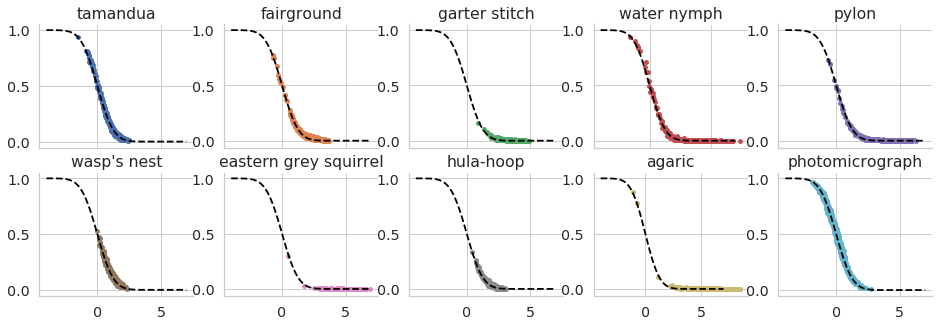

In [41]:
n_plots = 10
n_classes = 1000
with sns.axes_style('whitegrid'):    
    plt.figure(figsize=(16, n_plots//5*2.5))
    c = 0
    for i in range(n_plots):
        ax = plt.subplot(n_plots//5,5,i+1)
        plt.scatter(SNR[i],zse[i], c='C' + str(c%10), s=15)
        plt.title(names[i].split(',')[0])
        c+=1  # update color counter

        # Plot theory
#         x = np.linspace(np.nanmin(SNR[i]),np.nanmax(SNR[i])+1,50)
        x = np.linspace(-4,7,100)
        plt.plot(x, H(x), c='black', linestyle='dashed', linewidth=1.8, label='theory')
        if i <5:
            ax.set_xticklabels([])
#         plt.xlabel('SNR', fontsize=14)
#         if i%4==0:
#             plt.ylabel(r'$\epsilon_g$', fontsize=20)
#         if c==4:
#             plt.legend()
        sns.despine()
# plt.tight_layout()
# plt.savefig('images/zero_shot_errs.pdf')

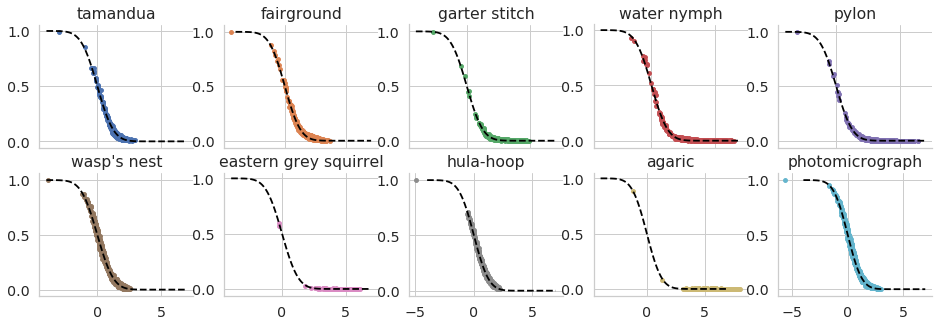

In [636]:
n_plots = 10
n_classes = 1000
with sns.axes_style('whitegrid'):    
    plt.figure(figsize=(16, n_plots//5*2.5))
    c = 0
    for i in range(n_plots):
        ax = plt.subplot(n_plots//5,5,i+1)
        plt.scatter(SNR[i],zse[i], c='C' + str(c%10), s=15)
        plt.title(names[i].split(',')[0])
        c+=1  # update color counter

        # Plot theory
#         x = np.linspace(np.nanmin(SNR[i]),np.nanmax(SNR[i])+1,50)
        x = np.linspace(-4,7,100)
        plt.plot(x, H(x), c='black', linestyle='dashed', linewidth=1.8, label='theory')
        if i <5:
            ax.set_xticklabels([])
#         plt.xlabel('SNR', fontsize=14)
#         if i%4==0:
#             plt.ylabel(r'$\epsilon_g$', fontsize=20)
#         if c==4:
#             plt.legend()
        sns.despine()
# plt.tight_layout()
# plt.savefig('images/zero_shot_errs.pdf')

Accuracy: 92.593%


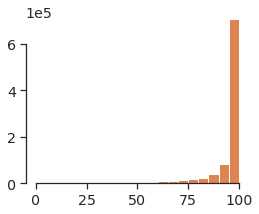

In [631]:
plt.figure(figsize=(4,3))
with sns.axes_style('ticks'):
    print('Accuracy: {:.3f}%'.format(100*(1-npo.nanmean(zse))))
#     ax.ticklabel_format(style='plain')
    plt.hist(100*(1-zse.ravel()), bins=20, color='C1');
    plt.ticklabel_format(axis='y', style='sci', scilimits=(1,5))
#     plt.xlim([50,100])
    plt.ylim([0.,7e5])
    sns.despine(trim=True)
    
plt.savefig('images/zero_shot_errs_hist.pdf')

In [425]:
# LEXSORT!!!
rp_full = np.copy(root_paths[:1000])
for i, rp in enumerate(rp_full):
    while len(rp) < 18:
        rp =  np.concatenate([[0],rp])
    rp_full[i] = rp
    
rp_full = np.stack(rp_full)
lexsort = np.lexsort(rp_full.T, axis=-1)

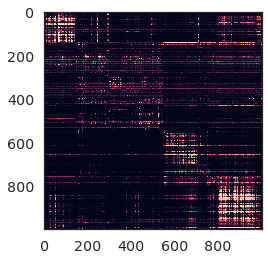

In [429]:
with sns.axes_style('white'):
    plt.imshow(zse[lexsort][:,lexsort]);

In [431]:
bp_idxs = []
classes = [
#             'bird',
            'mammal, mammalian',
#            'person, individual, someone, somebody, mortal, soul',
#            'food, nutrient',
#            'artifact, artefact',
#            'plant, flora, plant life',
#            'animal, animate being, beast, brute, creature, fauna',
          ]

for cls in classes:
    bp_idxs.append([i for i,rp in enumerate(root_paths) if np.isin(cls,rp)])
bp_idxs = np.concatenate(bp_idxs)

rp_bp = rp_full[bp_idxs]

bp_lexsort = np.lexsort(rp_bp.T)
bp_sort = bp_idxs[bp_lexsort]

In [434]:
np.array(names)[bp_idxs]

array(['tamandua, tamandu, lesser anteater, Tamandua tetradactyla',
       'eastern grey squirrel, eastern gray squirrel, cat squirrel, Sciurus carolinensis',
       'Abyssinian, Abyssinian cat', 'sausage dog, sausage hound',
       'coati, coati-mondi, coati-mundi, coon cat, Nasua narica',
       'vervet, vervet monkey, Cercopithecus aethiops pygerythrus',
       'golden hamster, Syrian hamster, Mesocricetus auratus', 'cow',
       'aardvark, ant bear, anteater, Orycteropus afer', 'carnivore',
       'thoroughbred',
       'Virginia deer, white tail, whitetail, white-tailed deer, whitetail deer, Odocoileus Virginianus',
       'lion cub', 'tiger cat', 'gelding',
       'river otter, Lutra canadensis', 'hack, jade, nag, plug',
       'numbat, banded anteater, anteater, Myrmecobius fasciatus',
       'tabby, queen', 'ewe',
       'Asiatic black bear, black bear, Ursus thibetanus, Selenarctos thibetanus',
       'black squirrel', 'ram, tup',
       'tortoiseshell, tortoiseshell-cat, cali

In [436]:
from utils import wnid_from_class
wnid_from_class('coati, coati-mondi, coati-mundi, coon cat, Nasua narica')

'n02509515'

In [505]:
i1 = np.argsort(-zse.mean(-1))

for i in i1[:10]:
    print(i,names[i])

799 special
269 roller
185 rosebud
225 lobster pot
224 banner, streamer
703 scapular
339 spoor
804 ao dai
543 popinjay
262 bird feeder, birdfeeder, feeder


In [481]:
names[543]

'popinjay'

In [470]:
from scipy.spatial.distance import squareform,pdist
wvdist = squareform(pdist(wvs))

In [689]:
names[np.argsort(wvdist[225])[6]]

'chicken broth, chicken stock'

In [691]:
np.where(np.array(names)=='cosmos, cosmea')

(array([164]),)

In [694]:
[name for name in names if 'oxeye' in name]

['oxeye daisy, ox-eyed daisy, marguerite, moon daisy, white daisy, Leucanthemum vulgare, Chrysanthemum leucanthemum']

In [695]:
np.where(np.array(names)=='oxeye daisy, ox-eyed daisy, marguerite, moon daisy, white daisy, Leucanthemum vulgare, Chrysanthemum leucanthemum')

(array([706]),)

In [687]:
i1,i2 = np.unravel_index(np.argsort((8-signal.ravel())**2 - 5*noise.ravel()),(K,K))

In [716]:
names[np.argsort(wvdist[164])[3]]

'sun, Sun'

In [688]:
for i in range(30):
    print('{:.2f}, {} vs {}'.format(zse[i1[i],i2[i]], names[i1[i]], names[i2[i]]))

0.40, sidecar vs cinnamon bread
0.38, sidecar vs gourd, calabash
0.40, sidecar vs marjoram, oregano
0.41, sidecar vs fondant
0.23, Japanese flowering cherry, Prunus sieboldii vs drawbridge, lift bridge
0.39, sidecar vs soup-strainer, toothbrush
0.40, sidecar vs sour bread, sourdough bread
0.40, sidecar vs chocolate egg
0.17, cow vs dinner dress, dinner gown, formal, evening gown
0.13, baseball bat, lumber vs soup-strainer, toothbrush
0.24, Japanese flowering cherry, Prunus sieboldii vs tramline, tramway, streetcar track
0.41, sidecar vs brioche
0.23, Japanese flowering cherry, Prunus sieboldii vs sluice, sluiceway, penstock
0.40, sidecar vs puree
0.28, Japanese flowering cherry, Prunus sieboldii vs city hall
0.40, sidecar vs cranberry sauce
0.39, sidecar vs potage, pottage
0.40, sidecar vs garlic bread
0.35, sidecar vs deviled egg, stuffed egg
0.39, sidecar vs lobster pot
0.27, Japanese flowering cherry, Prunus sieboldii vs trestle bridge
0.13, fireweed, Erechtites hieracifolia vs shor

In [614]:
names[i1[K+9]]

'corn chowder'

In [725]:
[name for name in names if 'cosmos' in name]

['cosmos, cosmea']

In [727]:
np.where(np.array(names)=='cosmos, cosmea')

(array([164]),)

In [730]:
100*(1-zse[164,706])

0.3999948501586914

In [680]:
wnid_from_class('headstock')

'n03506184'

In [646]:
1-zse[957,749]

0.9859999995678663

In [604]:
zse[i1[K+2],i2[K+2]]

0.13199999928474426

In [ ]:
# corn chowder vs chard

In [54]:
import numpy as np

In [44]:
noise = np.sqrt(css/500)

In [ ]:
i = 0
plt.figure(figsize=(4,4))
with sns.axes_style('whitegrid'):
    mask = np.eye(K,dtype='bool')
#     idxs = np.random.choice(np.arange(K*(K-1)),10000)
    idxs = np.arange(K*(K-1))
#     plt.scatter(noise[i1[i],i2[i]],signal[i1[i],i2[i]],zorder=999)
    plt.scatter(noise[~mask][idxs],signal[~mask][idxs], c=1-zse[~mask][idxs], s=5, cmap='coolwarm')
#     plt.xscale('log')
    plt.xlabel('noise')
    plt.ylabel('signal')
#     plt.xlim([0.2,2])
#     plt.xlim([-10,35])
    plt.colorbar()
    plt.savefig('images/zeroshot_scatter.png',dpi=1000)

In [128]:
# Consider the example 'oxeye daisy' vs 'cosmos'
n1 = 'oxeye daisy, ox-eyed daisy, marguerite,\
 moon daisy, white daisy, Leucanthemum vulgare,\
 Chrysanthemum leucanthemum'
n2 = 'cosmos, cosmea'

i1 = np.where(np.stack(names)[embedding_idx]==n1)[0][0]
i2 = np.where(np.stack(names)[embedding_idx]==n2)[0][0]

print('Zero shot error: {:0.2f}%'.format(zse.T[i1,i2]*100))

Zero shot error: 99.80%


# 21k

In [11]:
# Read synset files
import pandas as pd
wnids_21k = pd.read_csv('../manifold_old/data/imagenet_synset_list.txt').to_numpy().squeeze()

In [12]:
# Wordnet tools
import pandas as pd
wordnet = np.load('../manifold_old/data/wordnet_hierarchy.npy', allow_pickle=True)
synset_wnids = pd.read_csv('../manifold_old/data/words.txt', sep='\t')
synset_wnids = synset_wnids.to_numpy()

def class_from_wnid(wnid):
    return  synset_wnids[np.where(synset_wnids==wnid)[0], 1][0]

In [13]:
# Read synset files
synset_list = pd.read_csv('../manifold_old/data/imagenet_synset_list.txt')
synset_list = synset_list.to_numpy().squeeze()

# from utils import class_from_wnid
labels_21k = np.array([class_from_wnid(wnid) for wnid in synset_list])

In [14]:
# Keep only classes not in ILSVRC
ilsvrc_names = np.load('../manifold_old/data/ILSVRC_classes.npy')
# names = np.stack([name for name in names if not np.isin(name,ilsvrc_names)])

heldout_idxs = [i for i,name in enumerate(labels_21k) if not np.isin(name,ilsvrc_names)]

labels_20k = labels_21k[heldout_idxs]
wnids_20k = wnids_21k[heldout_idxs]

In [15]:
# Include only first name
wvs = []
embedding_idxs_all = []
for i,name in enumerate(labels_20k):
    wv = []
    parts = name.split(', ')
    for part in parts:
        subparts = part.split(' ')
        for subpart in subparts:
            subsubparts = subpart.split('-')
            for subsubpart in subsubparts:
                wvtmp = wordvecs[subsubpart.lower()].numpy()
                if np.any(wvtmp!=0):
                    wv.append(wvtmp)  
    if wv:
        embedding_idxs_all.append(i)
    else:
        wv = [np.nan*np.ones(300)]
    wvs.append(np.stack(wv).mean(0))
wvs = np.stack(wvs)
embedding_idxs_all = np.stack(embedding_idxs_all)

In [16]:
# # Keep only words with embeddings
# wvs = wvs[embedding_idxs_all]
# names = names[embedding_idxs_all]

In [17]:
# Normalize
wvs -= WVMEAN
wvs /= np.linalg.norm(wvs, axis=-1,keepdims=True)
wvs = np.nan_to_num(wvs)

In [18]:
# Procrustes
wve = map_procrustes(wvs,ax,ay,bx,by,O)

# Rigid
# wve_rigid = wvs@R.T + t

# wve_norm = wvs@Rnorm.T + tnorm
# # Least squares
# wve_ls = wvs@W + b
# wve_ls_norm = wvs@Wnorm + bnorm

In [19]:
# Make sure wvs with no embedding are set to nan
bad_idxs = np.setxor1d(np.arange(len(wve)),embedding_idxs_all)
for i in bad_idxs:
    wve[i] = np.nan*np.ones(2048)
#     wve_rigid[i] = np.nan*np.ones(2048)

## Data

In [20]:
# Find number of classes
path = '/mnt/fs2/bsorsch/manifold/held_out_imagenet/'
top_classes = np.load('/mnt/fs2/bsorsch/manifold/embeddings/1k_objects/names.npy')

In [21]:
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [22]:
img_dir = '/mnt/fs0/datasets/ImageNet21k/'
from PIL import Image

def get_batch(i, wnid_dir, imgs, batch_size):
    xbatch = []
    for img in imgs[i*batch_size:(i+1)*batch_size]:
        try:
            x = Image.open(os.path.join(wnid_dir, img)).convert('RGB')
            xbatch.append(preprocess(x))
        except:
            pass
    if len(xbatch)==0:
        return None
    else:
        return torch.stack(xbatch)

In [23]:
from torchvision.utils import make_grid
def show_grid(im_tensor, nrow=8, title=None):
    im_grid = make_grid(im_tensor, nrow=nrow, padding=2)
    im_grid = im_grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im_grid = std * im_grid + mean
    im_grid = np.clip(im_grid, 0, 1)
    
    plt.figure(figsize=(15,2*len(input_tensor)//nrow))
    plt.imshow(im_grid)
    plt.axis('off')
    plt.title(title)

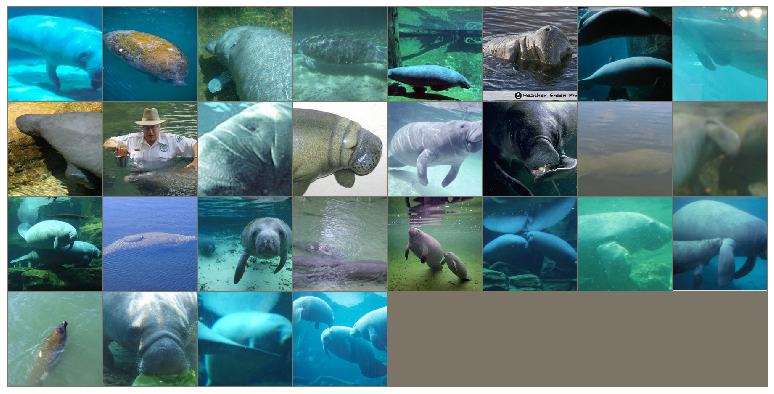

In [24]:
batch_size = 32
wnid = wnids_20k[12]
wnid_dir = os.path.join(img_dir, wnid)
imgs = os.listdir(wnid_dir)

input_tensor = get_batch(0, wnid_dir, imgs, batch_size)

show_grid(input_tensor)

## Model

In [31]:
import torch

In [32]:
model_name = 'resnet50'
# model_name = 'tf_efficientnet_l2_ns_475'
repo = 'pytorch/vision:v0.6.0'
# repo = 'rwightman/gen-efficientnet-pytorch'
model = torch.hub.load(repo, model_name, pretrained=True)

model_dir = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'+model_name+'/'

Using cache found in /home/bsorsch/.cache/torch/hub/pytorch_vision_v0.6.0


In [33]:
class WideResNetBackbone(torch.nn.Module):
    def __init__(self, model, module_idx):
        super(WideResNetBackbone, self).__init__()
        self.N = list(model.children())[-1].weight.shape[-1]
        self.features = torch.nn.Sequential(*list(model.children())[:-module_idx])
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        return x

In [34]:
backbone = WideResNetBackbone(model, 1)
backbone = backbone.cuda().eval();

In [35]:
# wve = wve[heldout_idxs]
# wve_norm = wve_norm[heldout_idxs]
# wve_ls = wve_ls[heldout_idxs]
# wve_ls_norm = wve_ls_norm[heldout_idxs]

In [36]:
wve = torch.tensor(wve).cuda().float()
# wve_rigid = torch.tensor(wve_rigid).cuda().float()
# wve_norm = torch.tensor(wve_norm).cuda().float()
# wve_ls = torch.tensor(wve_ls).cuda().float()
# wve_ls_norm = torch.tensor(wve_ls_norm).cuda().float()

## Compute error

In [35]:
def acc(i,output,wv):
    preds1 = []
    preds5 = []
    preds10 = []
#     preds1_cos = []
#     preds5_cos = []
#     preds10_cos = []
    for xi in output:
        dists = ((xi - wv)**2).sum(-1)
        neighbors = torch.argsort(dists).cpu().numpy()
        preds1.append(np.isin(i,neighbors[0]))
        preds5.append(np.isin(i,neighbors[:5]))
        preds10.append(np.isin(i,neighbors[:10]))

#         cos_ang = wv@xi / torch.norm(xi) / torch.norm(wv, dim=-1)
#         neighbors = torch.argsort(1-cos_ang).cpu().numpy()
#         preds1_cos.append(np.isin(i,neighbors[0]))
#         preds5_cos.append(np.isin(i,neighbors[:5]))
#         preds10_cos.append(np.isin(i,neighbors[:10]))
    acc1 = np.mean(preds1)
    acc5 = np.mean(preds5)
    acc10 = np.mean(preds10)
#     acc1_cos = np.mean(preds1_cos)
#     acc5_cos = np.mean(preds5_cos)
#     acc10_cos = np.mean(preds10_cos)
#     return acc1,acc5,acc10,acc1_cos,acc5_cos,acc10_cos
    return acc1,acc5,acc10

In [44]:
def zero_shot_acc(i,class_dir,imgs,batch_size,wv,ks,norm=False):
    ''' Compute zero shot accuracy for a given class '''

    # Ensure batch size does not exceed num images    
    tmp_batch_size = np.minimum(len(imgs),batch_size)

    neighbors = []
    neighbors_cos = []
    accs = {}
#     accs_cos = {}
    for j in range(1+len(imgs)//tmp_batch_size):
        # Get input batch
        input_tensor = get_batch(j, class_dir, imgs, tmp_batch_size)
        if input_tensor is not None:
            # Get model ouput
            with torch.no_grad():
                output = backbone(input_tensor.cuda())

            # Normalize
            if norm:
                output /= torch.norm(output, dim=-1, keepdim=True)

            for xi in output:
                dists = ((xi - wv)**2).sum(-1)
                neighbors.append(torch.argsort(dists)[:20])
#                 cos_ang = wv@xi / torch.norm(xi) / torch.norm(wv, dim=-1)
#                 neighbors_cos.append(torch.argsort(1-cos_ang)[:20])
            
    if len(neighbors) == 0:
        return None,None,None
    else:
        neighbors = torch.stack(neighbors)
#         neighbors_cos = torch.stack(neighbors_cos)

        # Compute accuracies
        for k in ks:
            acc = torch.sum(i==neighbors[:,:k],dtype=torch.float32) / len(neighbors)
            accs[k] = acc.item()
#             acc_cos = torch.sum(i==neighbors_cos[:,:k],dtype=torch.float32) / len(neighbors_cos)
#             accs_cos[k] = acc_cos.item()

        # Most common guesses
        uniq, counts = torch.unique(neighbors,return_counts=True)
        guesses = uniq[torch.argsort(-counts)[:5]].cpu().numpy()

        nimgs = len(neighbors)

        return accs, guesses, nimgs

In [40]:
def nanmean(v, *args, inplace=False, **kwargs):
    if not inplace:
        v = v.clone()
    is_nan = torch.isnan(v)
    v[is_nan] = 0
    return v.sum(*args, **kwargs) / (~is_nan).float().sum(*args, **kwargs)


# Construct linear readout
mu = nanmean(wve,0)
K = len(wve)

ws = []
ws_rigid = []
for i in tqdm(range(K)):
    ya = wve[i]
    yb = nanmean(wve[np.arange(K)!=i],0)
    w = ya-yb
    ws.append(w)
    
#     ya = wve_rigid[i]
#     yb = nanmean(wve_rigid[np.arange(K)!=i],0)
#     w = ya-yb
#     ws_rigid.append(w)
ws = torch.stack(ws).T
# ws_rigid = torch.stack(ws_rigid).T

In [41]:
def zero_shot_acc_linear(i,class_dir,imgs,batch_size,W,ks,norm=False):
    ''' Compute zero shot accuracy with a linear classifier for a given class '''

    # Ensure batch size does not exceed num images    
    tmp_batch_size = np.minimum(len(imgs),batch_size)

    neighbors = []
    neighbors_cos = []
    accs = {}
#     accs_cos = {}
    for j in range(1+len(imgs)//tmp_batch_size):
        # Get input batch
        input_tensor = get_batch(j, class_dir, imgs, tmp_batch_size)
        if input_tensor is not None:
            # Get model ouput
            with torch.no_grad():
                output = backbone(input_tensor.cuda())

            h = (output - mu)@W
            h[torch.isnan(h)]= -1e10
            neighbors.append(torch.argsort(-h, dim=-1)[:,:20])
            
    if len(neighbors) == 0:
        return None,None,None
    else:
        neighbors = torch.cat(neighbors)

    # Compute accuracies
    for k in ks:
        acc = torch.sum(i==neighbors[:,:k],dtype=torch.float32) / len(neighbors)
        accs[k] = acc.item()
#             acc_cos = torch.sum(i==neighbors_cos[:,:k],dtype=torch.float32) / len(neighbors_cos)
#             accs_cos[k] = acc_cos.item()

    # Most common guesses
    uniq, counts = torch.unique(neighbors,return_counts=True)
    guesses = uniq[torch.argsort(-counts)[:5]].cpu().numpy()

    nimgs = len(neighbors)

    return accs, guesses, nimgs

In [ ]:
batch_size = 32
n_avg = 1000
ks = [1,2,5,10,20]

# Set up accuracy dicts
# accs_rigid = {}
# accs_rigid_linear = {}
# accs_procrustes = {}
accs_procrustes_linear = {}
# accs_rigid_norm = {}
# accs_ls = {}
# accs_ls_norm = {}
# accs_rigid_cos = {}
# accs_rigid_norm_cos = {}
# accs_ls_cos = {}
# accs_ls_norm_cos = {}
for k in ks:
#     accs_rigid[k] = []
#     accs_rigid_linear[k] = []
#     accs_procrustes[k] = []
    accs_procrustes_linear[k] = []
#     accs_rigid_norm[k] = []
#     accs_ls[k] = []
#     accs_ls_norm[k] = []
#     accs_rigid_cos[k] = []
#     accs_rigid_norm_cos[k] = []
#     accs_ls_cos[k] = []
#     accs_ls_norm_cos[k] = []

nimgs = []
wnids = []
idxs = []
# perm = np.random.permutation(len(wnids_20k))    # proceed in random order

T = len(wnids_20k)
perm = np.arange(T)
for i in tqdm(range(T//4)):
    idx = perm[i]
    wnid = wnids_20k[idx]
    wnid_dir = os.path.join(img_dir, wnid)
    imgs = os.listdir(wnid_dir)

#     # Procrustes
#     acc_tmp, guesses, nimgs_tmp = zero_shot_acc(idx,wnid_dir,imgs,batch_size,wve,ks)
#     if acc_tmp:
#         for k in ks:
#             accs_procrustes[k].append(acc_tmp[k])
        
#     # Rigid
#     acc_tmp, guesses, nimgs_tmp = zero_shot_acc(idx,wnid_dir,imgs,batch_size,wve_rigid,ks)
#     if acc_tmp:
#         for k in ks:
#             accs_rigid[k].append(acc_tmp[k])
        
    # Procrustes linear
    acc_tmp, guesses, nimgs_tmp = zero_shot_acc_linear(idx,wnid_dir,imgs,batch_size,ws,ks)
    if acc_tmp:
        for k in ks:
            accs_procrustes_linear[k].append(acc_tmp[k])
        print('Class: ' + str(labels_20k[idx]))
        guessnames = labels_20k[guesses]
        guessnames = [gn.split(',')[0] for gn in guessnames]
        print('Top guesses: ' + '; '.join(guessnames))
        
#     # Rigid linear
#     acc_tmp, guesses, nimgs_tmp = zero_shot_acc_linear(idx,wnid_dir,imgs,batch_size,ws_rigid,ks)
#     if acc_tmp:
#         for k in ks:
#             accs_rigid_linear[k].append(acc_tmp[k])

#         # LS
#         (acc_tmp, acc_cos_tmp,
#          guesses, nimgs_tmp) = zero_shot_acc(i,class_dir,imgs,tmp_batch_size,wve_ls,ks)
#         if acc_tmp:
#             for k in ks:
#                 accs_ls[k].append(acc_tmp[k])
#                 accs_ls_cos[k].append(acc_cos_tmp[k])

#     # Rigid norm
#     (acc_tmp, acc_cos_tmp,
#      guesses, nimgs_tmp) = zero_shot_acc(i,class_dir,imgs,batch_size,wve_norm,ks,norm=False)
#     if acc_tmp:
#         for k in ks:
#             accs_rigid_norm[k].append(acc_tmp[k])
#             accs_rigid_norm_cos[k].append(acc_cos_tmp[k])
        
#         # Ls norm
#         (acc_tmp, acc_cos_tmp,
#          guesses, nimgs_tmp) = zero_shot_acc(i,class_dir,imgs,tmp_batch_size,wve_ls_norm,ks,norm=True)
#         if acc_tmp:
#             for k in ks:
#                 accs_ls_norm[k].append(acc_tmp[k])
#                 accs_ls_norm_cos[k].append(acc_cos_tmp[k])

    if acc_tmp:
        wnids.append(wnid)
        idxs.append(idx)
        nimgs.append(nimgs_tmp)

    if i % 10 == 9:
        print('Procrustes linear: acc1= {:.2f}%, acc5={:.2f}%, acc10={:.2f}%'.format(
                100*np.sum(np.stack(accs_procrustes_linear[1])*np.stack(nimgs)) / np.sum(nimgs),
                100*np.sum(np.stack(accs_procrustes_linear[5])*np.stack(nimgs)) / np.sum(nimgs),
                100*np.sum(np.stack(accs_procrustes_linear[10])*np.stack(nimgs)) / np.sum(nimgs)))
        
        
    if i % 100 == 0:
        print('Saving...')
        np.save(os.path.join(model_dir,'zero_shot_accs.npy'),accs_procrustes_linear)
        np.save(os.path.join(model_dir,'zero_shot_idxs.npy'),idxs)
        np.save(os.path.join(model_dir,'zero_shot_nimgs.npy'),nimgs)

Class: proconsul
Top guesses: dress suit; necktie; dinner jacket; leotard; attire
Saving...
Class: Sinanthropus, genus Sinanthropus
Top guesses: tooth shell; pleurodont; protoceratops; pachycephalosaur; ankylosaur
Class: hinny
Top guesses: cattle; aoudad; wisent; ox; domestic sheep
Class: round-tailed muskrat, Florida water rat, Neofiber alleni
Top guesses: ferret badger; European rabbit; opossum rat; pouched mouse; rabbit-eared bandicoot
Class: Japanese deer, sika, Cervus nipon, Cervus sika
Top guesses: aoudad; gemsbok; common eland; nilgai; mule deer
Class: quagga, Equus quagga
Top guesses: mountain zebra; horse; giraffe; grevy's zebra; Przewalski's horse
Class: brown rat, Norway rat, Rattus norvegicus
Top guesses: opossum rat; European rabbit; bassarisk; beaver rat; pouched mouse
Class: Plott hound
Top guesses: Romanian; toby; Yugoslav; matchboard; coonhound
Class: California sea lion, Zalophus californianus, Zalophus californicus
Top guesses: walrus; sea otter; sea cow; shark; porp

/home/bsorsch/.torch3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


Class: harnessed antelope
Top guesses: nilgai; blackbuck; gemsbok; grevy's zebra; common zebra
Class: wolfhound
Top guesses: wolfhound; Welsh terrier; wirehair; Clydesdale terrier; shepherd dog
Class: vaquita, Phocoena sinus
Top guesses: finback; whitetip shark; whale shark; whitetip shark; sandbar shark
Class: American flying squirrel
Top guesses: bassarisk; smoothhound; antelope squirrel; longtail weasel; red squirrel
Class: Alaskan brown bear, Kodiak bear, Kodiak, Ursus middendorffi, Ursus arctos middendorffi
Top guesses: grizzly; Alaskan brown bear; Asiatic black bear; Syrian bear; bear
Class: silky tamarin, Leontocebus rosalia
Top guesses: vervet; talapoin; tailless tenrec; tamarin; lemur
Procrustes linear: acc1= 13.19%, acc5=27.38%, acc10=31.81%
Class: common raccoon, common racoon, coon, ringtail, Procyon lotor
Top guesses: bassarisk; ferret badger; hog badger; musteline mammal; American mink
Class: white rhinoceros, Ceratotherium simum, Diceros simus
Top guesses: wisent; common

Class: jerboa
Top guesses: rabbit-eared bandicoot; pouched mouse; chevrotain; opossum rat; pika
Class: Java man, Trinil man
Top guesses: cartilaginous fish; pachycephalosaur; headpiece; cocktail dress; ichthyosaurus
Class: chacma, chacma baboon, Papio ursinus
Top guesses: rhesus; chacma; vervet; Barbary ape; talapoin
Class: mastodon, mastodont
Top guesses: elephant; rhinoceros; tyrannosaur; protoceratops; ceratopsian
Class: wirehair, wirehaired terrier, wire-haired terrier
Top guesses: terrier; Welsh terrier; Clydesdale terrier; wirehair; fox terrier
Procrustes linear: acc1= 7.63%, acc5=20.44%, acc10=27.94%
Class: suslik, souslik, Citellus citellus
Top guesses: chevrotain; rabbit-eared bandicoot; antelope squirrel; red squirrel; bassarisk
Class: kangaroo mouse
Top guesses: rabbit-eared bandicoot; pouched mouse; opossum rat; bandicoot rat; pika
Class: kitty, kitty-cat, puss, pussy, pussycat
Top guesses: big cat; cat; cat fancier; cat-o'-nine-tails; tiger cat
Class: shepherd dog, sheepdo

Class: sand rat
Top guesses: bandicoot rat; rabbit-eared bandicoot; rabbit burrow; pouched mouse; dormouse
Class: red fox, Vulpes fulva
Top guesses: red fox; fox; jackal; bassarisk; dog
Class: mole rat
Top guesses: musteline mammal; lagomorph; marsupial; sea cow; bassarisk
Procrustes linear: acc1= 8.30%, acc5=23.61%, acc10=30.93%
Class: great ape, pongid
Top guesses: rhesus; pygmy chimpanzee; anthropoid ape; ape; monkey
Class: tapir
Top guesses: wolverine; wisent; American bison; blackbuck; nilgai
Class: slow loris, Nycticebus tardigradua, Nycticebus pygmaeus
Top guesses: lemur; bassarisk; flying lemur; tamarin; squirrel
Class: collared peccary, javelina, Tayassu angulatus, Tayassu tajacu, Peccari angulatus
Top guesses: chevrotain; mule deer; hog badger; boar; roe deer
Class: aurochs, urus, Bos primigenius
Top guesses: wisent; goat antelope; cattle; ox; American bison
Class: kangaroo mouse, dwarf pocket rat
Top guesses: rabbit-eared bandicoot; opossum rat; pouched mouse; bandicoot rat;

Class: blacktail prairie dog, Cynomys ludovicianus
Top guesses: chevrotain; rabbit-eared bandicoot; hog badger; otter shrew; beaver rat
Class: blue fox
Top guesses: caribou; American mink; Alaskan brown bear; musteline mammal; red fox
Class: setter
Top guesses: spaniel; English toy spaniel; toy spaniel; field spaniel; setter
Class: kanchil, Tragulus kanchil
Top guesses: rabbit-eared bandicoot; chevrotain; bandicoot rat; white-footed mouse; bassarisk
Class: bruin
Top guesses: grizzly; wolverine; Alaskan brown bear; Asiatic black bear; bear
Class: Steller's sea cow, Hydrodamalis gigas
Top guesses: whale shark; whitetip shark; whitetip shark; shark; porbeagle
Class: markhor, markhoor, Capra falconeri
Top guesses: goat antelope; aoudad; nilgai; red deer; common eland
Class: red-backed mouse, redback vole
Top guesses: opossum rat; rabbit-eared bandicoot; pouched mouse; bandicoot rat; beaver rat
Class: musk ox, musk sheep, Ovibos moschatus
Top guesses: wisent; goat antelope; ox; cattle; auro

Class: bottlenose dolphin, bottle-nosed dolphin, bottlenose
Top guesses: whitetip shark; whale shark; finback; blacktip shark; whale
Class: hooded skunk, Mephitis macroura
Top guesses: spotted skunk; hog-nosed skunk; hog badger; ferret badger; common raccoon
Class: anthropoid
Top guesses: rhesus; vervet; pygmy chimpanzee; monkey; tamarin
Class: cactus mouse, Peromyscus eremicus
Top guesses: pouched mouse; red squirrel; rabbit-eared bandicoot; opossum rat; pika
Class: domestic sheep, Ovis aries
Top guesses: domestic sheep; wisent; aoudad; cattle; sheep
Class: wild horse
Top guesses: aoudad; goat antelope; cattle; gemsbok; wisent
Class: deer, cervid
Top guesses: aoudad; gemsbok; pronghorn; common eland; nilgai
Class: liver-spotted dalmatian
Top guesses: sled dog; hound; coach horse; dachshund; sporting dog
Procrustes linear: acc1= 7.80%, acc5=20.42%, acc10=27.20%
Class: Cape buffalo, Synercus caffer
Top guesses: wisent; goat antelope; American bison; ox; pronghorn
Class: red poll
Top gue

Class: beaked whale
Top guesses: finback; bowhead; whitetip shark; white whale; lesser rorqual
Class: polar hare, Arctic hare, Lepus arcticus
Top guesses: snowshoe hare; polar hare; pika; hare wallaby; white-tailed jackrabbit
Class: blue whale, sulfur bottom, Balaenoptera musculus
Top guesses: finback; bowhead; whale; whaler; lesser rorqual
Procrustes linear: acc1= 8.28%, acc5=20.35%, acc10=26.81%
Class: addax, Addax nasomaculatus
Top guesses: goat antelope; aoudad; pronghorn; antelope; common eland
Saving...
Class: white-lipped peccary, Tayassu pecari
Top guesses: mule deer; chevrotain; hog badger; boar; roe deer
Class: pinche, Leontocebus oedipus
Top guesses: vervet; talapoin; monkey; tamarin; bonnet macaque
Class: eastern chimpanzee, Pan troglodytes schweinfurthii
Top guesses: pygmy chimpanzee; rhesus; central chimpanzee; vervet; anthropoid ape
Class: wild sheep
Top guesses: goat antelope; domestic sheep; aoudad; mule deer; pronghorn
Class: dik-dik
Top guesses: antelope squirrel; wh

Class: vespertilian bat, vespertilionid
Top guesses: bassarisk; musteline mammal; marten; feline; striped skunk
Class: palm cat, palm civet
Top guesses: bassarisk; ocelot; margay; musteline mammal; longtail weasel
Class: polo pony
Top guesses: cavalry horse; horseman; horse; saddle horse; riding
Class: spearnose bat
Top guesses: garter stitch; mottle; punctum; tomato hornworm; cat's-claw
Class: yearling
Top guesses: cattle; wild horse; cavalry horse; ox; carthorse
Class: griffon, wire-haired pointing griffon
Top guesses: terrier; Skye terrier; wirehair; Manchester terrier; fox terrier
Class: lioness
Top guesses: leopard; lion-hunter; lion cub; leopard cat; bobcat
Class: Belgian sheepdog, Belgian shepherd
Top guesses: Belgian sheepdog; shepherd dog; dachshund; pinscher; marten
Class: domestic llama, Lama peruana
Top guesses: aoudad; cattle; domestic sheep; wisent; aurochs
Procrustes linear: acc1= 7.84%, acc5=19.32%, acc10=25.56%
Class: mountain nyala, Tragelaphus buxtoni
Top guesses: ao

Class: bandicoot rat, mole rat
Top guesses: musteline mammal; lagomorph; pouched mouse; bassarisk; opossum rat
Class: Cashmere goat, Kashmir goat
Top guesses: cattle; domestic sheep; aoudad; wisent; goat antelope
Procrustes linear: acc1= 7.16%, acc5=18.18%, acc10=24.29%
Class: lesser ape
Top guesses: lemur; guereza; vervet; rhesus; talapoin
Class: hackney
Top guesses: cavalry horse; carthorse; draft horse; vaulting horse; plow horse
Class: working dog
Top guesses: dachshund; shepherd dog; Welsh terrier; pinscher; wirehair
Class: brown bat
Top guesses: bassarisk; musteline mammal; raccoon dog; pouched mouse; opossum rat
Class: roebuck
Top guesses: pronghorn; gemsbok; aoudad; common eland; nilgai
Class: elephant
Top guesses: elephant; rhinoceros; elephant seal; common eland; giant eland
Class: dwarf sperm whale, Kogia simus
Top guesses: finback; pilot whale; humpback; porpoise; sandbar shark
Class: Desmodus rotundus
Top guesses: bassarisk; musteline mammal; opossum rat; feline; raccoon d

Class: grade
Top guesses: ox; wisent; cattle; goat antelope; American bison
Class: chevrotain, mouse deer
Top guesses: rabbit-eared bandicoot; bassarisk; hog-nosed skunk; antelope squirrel; opossum rat
Class: Malayan tapir, Indian tapir, Tapirus indicus
Top guesses: wisent; blackbuck; wolverine; American bison; rhinoceros
Class: Belgian hare, leporide
Top guesses: hare wallaby; snowshoe hare; pika; rabbit burrow; rabbit ears
Procrustes linear: acc1= 7.25%, acc5=17.92%, acc10=23.86%
Class: lerot
Top guesses: bassarisk; longtail weasel; ferret badger; red squirrel; rabbit-eared bandicoot
Class: agouti, Dasyprocta aguti
Top guesses: rabbit-eared bandicoot; opossum rat; pouched mouse; bandicoot rat; beaver rat
Class: English toy spaniel
Top guesses: English toy spaniel; toy spaniel; spaniel; field spaniel; water spaniel
Class: peludo, poyou, Euphractus sexcinctus
Top guesses: pangolin; peba; chevrotain; hog-nosed skunk; antelope squirrel
Class: squirrel
Top guesses: squirrel; rabbit-eared 

Class: Indian buffalo
Top guesses: ox; goat antelope; cattle; American bison; harnessed antelope
Saving...
Class: red squirrel, cat squirrel, Sciurus vulgaris
Top guesses: bassarisk; red squirrel; squirrel; rabbit-eared bandicoot; eastern grey squirrel
Class: ape
Top guesses: rhesus; pygmy chimpanzee; ape; anthropoid ape; mountain gorilla
Class: rice rat, Oryzomys palustris
Top guesses: rabbit-eared bandicoot; beaver rat; pouched mouse; opossum rat; bassarisk
Class: elk, European elk, moose, Alces alces
Top guesses: goat antelope; aoudad; pronghorn; common eland; gemsbok
Class: digitigrade mammal, digitigrade
Top guesses: jackal; tiger cat; dog; Alaskan brown bear; margay
Class: raccoon, racoon
Top guesses: bassarisk; ferret badger; hog badger; marten; musteline mammal
Class: humpback, humpback whale, Megaptera novaeangliae
Top guesses: finback; whale; bowhead; pilot whale; lesser rorqual
Procrustes linear: acc1= 7.35%, acc5=18.45%, acc10=24.55%
Class: peba, nine-banded armadillo, Texa

Class: tamarisk gerbil, Meriones unguiculatus
Top guesses: opossum rat; rabbit-eared bandicoot; pouched mouse; European rabbit; bassarisk
Class: Homo soloensis
Top guesses: giant conch; tooth shell; scallop shell; spherule; caryatid
Class: American water spaniel
Top guesses: retriever; spaniel; field spaniel; toy spaniel; wirehair
Procrustes linear: acc1= 7.17%, acc5=18.10%, acc10=24.38%
Class: porpoise
Top guesses: whitetip shark; finback; whale shark; sandbar shark; shark
Class: toy dog, toy
Top guesses: terrier; toy spaniel; poodle; wirehair; English toy spaniel
Class: pangolin, scaly anteater, anteater
Top guesses: dachshund; ferret badger; hog badger; bassarisk; rabbit-eared bandicoot
Class: seal
Top guesses: sea otter; Eurasian otter; sea cow; walrus; Steller sea lion
Class: bearded seal, squareflipper square flipper, Erignathus barbatus
Top guesses: sea otter; porpoise; Eurasian otter; walrus; sea cow
Class: retriever
Top guesses: retriever; spaniel; dachshund; toy spaniel; fiel

Class: phalanger, opossum, possum
Top guesses: bassarisk; ferret badger; longtail weasel; dachshund; musteline mammal
Class: dasyurid marsupial, dasyurid
Top guesses: bassarisk; opossum rat; rabbit-eared bandicoot; ferret badger; red squirrel
Class: native cat, Dasyurus viverrinus
Top guesses: bassarisk; margay; ocelot; red squirrel; longtail weasel
Class: mole
Top guesses: bread sauce; cheese sauce; hot-fudge sauce; spaghetti sauce; steak sauce
Class: Mediterranean water shrew, Neomys anomalus
Top guesses: bassarisk; opossum rat; longtail weasel; pouched mouse; rabbit-eared bandicoot
Class: placental, placental mammal, eutherian, eutherian mammal
Top guesses: antelope squirrel; wisent; bassarisk; common eland; nilgai
Class: tenrec, tendrac
Top guesses: opossum rat; pangolin; pouched mouse; musteline mammal; longtail weasel
Procrustes linear: acc1= 7.01%, acc5=17.59%, acc10=23.75%
Class: brewer's mole, hair-tailed mole, Parascalops breweri
Top guesses: musteline mammal; bassarisk; grou

Class: watch, ticker
Top guesses: analog watch; wristwatch; chronograph; clock; timepiece
Class: penguin
Top guesses: goosander; merganser; hog badger; rock hopper; ferret badger
Class: alligator, gator
Top guesses: Asian crocodile; crocodilian reptile; alligator snapping turtle; Morlett's crocodile; crocodile
Class: frog, toad, toad frog, anuran, batrachian, salientian
Top guesses: frog; leopard frog; horned lizard; leptodactylid frog; tongueless frog
Class: sunflower, helianthus
Top guesses: oxeye daisy; violet-flowered petunia; Easter daisy; camphor daisy; daisybush
Class: menorah
Top guesses: glow lamp; vigil light; lamp; Aladdin's lamp; lamp
Class: euphonium
Top guesses: bass horn; baritone; clarinet; flugelhorn; horn
Class: bonsai
Top guesses: pot; drip pot; gazebo; crucible; garden
Procrustes linear: acc1= 6.60%, acc5=16.68%, acc10=22.78%
Class: bumper car, Dodgem
Top guesses: minibike; car; club car; car; bumper car
Class: bogy, bogie, bogey
Top guesses: truss bridge; trestle b

Class: car-ferry
Top guesses: tugboat; sailing vessel; passenger ship; vessel; sailboat
Procrustes linear: acc1= 6.37%, acc5=16.66%, acc10=23.07%
Class: ferry, ferryboat
Top guesses: sailing vessel; tugboat; passenger ship; cargo ship; steamer
Saving...
Class: guard boat
Top guesses: vessel; sailboat; sailing vessel; steamer; boat
Class: gunboat
Top guesses: sailing vessel; vessel; bottom; sailing warship; cargo ship
Class: junk
Top guesses: sailing vessel; sailing warship; sailboat; tugboat; sloop
Class: lugger
Top guesses: sailing vessel; sailing warship; sailboat; sloop; sail
Class: mackinaw, Mackinaw boat
Top guesses: sailing vessel; tugboat; sailing warship; steamer; cargo ship
Class: mailboat, mail boat, packet, packet boat
Top guesses: passenger ship; whaler; sailing vessel; ship; bottom
Class: cabin cruiser, cruiser, pleasure boat, pleasure craft
Top guesses: sailboat; vessel; sailing vessel; boat; steamer
Class: launch
Top guesses: sailing vessel; vessel; sailboat; sailing war

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Class: sailing vessel, sailing ship
Top guesses: sailing vessel; sailing warship; sloop; clipper; whaler
Class: abandoned ship, derelict
Top guesses: tugboat; sailing vessel; ship; whaler; bottom
Class: blockade-runner
Top guesses: vessel; steamer; warship; ship; tugboat
Class: banana boat
Top guesses: sailboat; surfboat; boat; rowing boat; motorboat
Class: bottom, freighter, merchantman, merchant ship
Top guesses: cargo ship; sailing vessel; bottom; ship; passenger ship
Class: cattleship, cattle boat
Top guesses: sailing vessel; passenger ship; ship; cargo ship; bottom
Class: Liberty ship
Top guesses: cargo ship; passenger ship; bottom; sailing vessel; ship
Procrustes linear: acc1= 6.33%, acc5=16.86%, acc10=23.48%
Class: supertanker
Top guesses: bottom; cargo ship; sailing vessel; ship; passenger ship
Class: oil tanker, oiler, tanker, tank ship
Top guesses: sailing vessel; cargo ship; bottom; ship; passenger ship
Class: cargo ship, cargo vessel
Top guesses: cargo ship; sailing vessel;

Class: tank, army tank, armored combat vehicle, armoured combat vehicle
Top guesses: tank; armored vehicle; tank engine; tank car; tank destroyer
Class: troop carrier, troop transport
Top guesses: armored vehicle; tank; armored car; armored car; wheeled vehicle
Class: weapons carrier
Top guesses: armored vehicle; armored car; tank; armored car; wheeled vehicle
Class: military vehicle
Top guesses: armored vehicle; armored car; armored car; tank; wheeled vehicle
Class: air-to-air missile
Top guesses: fleet ballistic missile submarine; aircraft; ballistic missile; stealth aircraft; intercontinental ballistic missile
Class: air-to-ground missile, air-to-surface missile
Top guesses: stealth aircraft; aircraft; naval missile; drone; fleet ballistic missile submarine
Class: Minuteman
Top guesses: rocket; ballistic missile; air-to-ground missile; intercontinental ballistic missile; fleet ballistic missile submarine
Procrustes linear: acc1= 6.26%, acc5=16.73%, acc10=23.45%
Class: intercontinent

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41730
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Class: push-bike
Top guesses: bicycle; motorcycle; bicycle wheel; trail bike; safety bicycle
Class: safety bicycle, safety bike
Top guesses: bicycle; motorcycle; bicycle wheel; trail bike; safety bicycle
Class: velocipede
Top guesses: bicycle wheel; bicycle; bicycle pump; bicycle rack; motorcycle
Class: bicycle, bike, wheel, cycle
Top guesses: bicycle; bicycle wheel; motorcycle; bicycle pump; bicycle rack
Class: boneshaker
Top guesses: bicycle wheel; bicycle; bicycle pump; bicycle rack; motorcycle
Class: baggage car, luggage van
Top guesses: car; passenger train; locomotive; freight train; train
Procrustes linear: acc1= 6.39%, acc5=16.97%, acc10=23.81%
Class: cabin car, caboose
Top guesses: locomotive; freight train; car; diesel locomotive; train
Class: club car, lounge car
Top guesses: dining car; passenger train; car train; hospital train; train
Class: stockcar
Top guesses: passenger train; freight elevator; car; locomotive; carriage
Class: boxcar
Top guesses: freight train; car; pas

Class: locomotive, engine, locomotive engine, railway locomotive
Top guesses: locomotive; diesel locomotive; car; train; freight train
Class: swamp buggy, marsh buggy
Top guesses: wheeled vehicle; truck; armored vehicle; motor vehicle; hand truck
Class: bloodmobile
Top guesses: car train; bus; camper; passenger train; truck
Class: funny wagon
Top guesses: car train; cruiser; truck; bus; armored car
Class: shooting brake
Top guesses: touring car; cab; car door; roadster; sedan
Class: gypsy cab
Top guesses: car train; cruiser; bus; truck; car
Class: compact, compact car
Top guesses: touring car; car door; cable car; cab; subcompact
Class: coupe
Top guesses: touring car; cab; car door; subcompact; roadster
Class: panda car
Top guesses: cruiser; car train; sport utility; jaunting car; armored car
Class: cruiser, police cruiser, patrol car, police car, prowl car, squad car
Top guesses: cruiser; car train; car; jaunting car; car
Procrustes linear: acc1= 6.37%, acc5=17.18%, acc10=24.18%
Class

Class: upper berth, upper
Top guesses: living room; dining-room furniture; bedroom; dining-room table; bedroom furniture
Class: berth, bunk, built in bed
Top guesses: living room; dining-room furniture; sofa; sewing room; dining-room table
Class: bunk
Top guesses: living room; dining-room furniture; sewing room; sofa; bedroom
Class: bunk bed, bunk
Top guesses: living room; dining-room furniture; sewing room; dining-room table; bedroom
Class: cot, camp bed
Top guesses: easy chair; swivel chair; deck chair; chair; wing chair
Procrustes linear: acc1= 6.21%, acc5=17.10%, acc10=24.18%
Class: couch
Top guesses: sofa; convertible; baby bed; couch; Murphy bed
Class: double bed
Top guesses: bedroom; sofa; convertible; daybed; living room
Class: hammock, sack
Top guesses: outrigger canoe; outrigger; baby buggy; rope bridge; sailboat
Class: marriage bed
Top guesses: baby bed; Job's comforter; bedroom; bed; bed
Class: Murphy bed
Top guesses: living room; dining-room furniture; bedroom; child's roo

Class: motorized wheelchair
Top guesses: power mower; riding mower; hand mower; scooter; automobile engine
Class: wheelchair
Top guesses: motorcycle; bicycle; bicycle wheel; minibike; bicycling
Class: chair
Top guesses: easy chair; recliner; lawn chair; captain's chair; chair
Class: ottoman, pouf, pouffe, puff, hassock
Top guesses: sofa; recliner; convertible; bedroom furniture; living room
Procrustes linear: acc1= 6.08%, acc5=16.80%, acc10=23.80%
Class: chesterfield
Top guesses: convertible; sofa; couch; couch; Murphy bed
Class: davenport
Top guesses: dining-room table; bedroom furniture; dining-room furniture; bedroom; living room
Class: convertible, sofa bed
Top guesses: convertible; sofa; couch; bed; couch
Class: daybed, divan bed
Top guesses: convertible; sofa; baby bed; daybed; bed
Class: divan
Top guesses: convertible; couch; couch; baby bed; Job's comforter
Class: love seat, loveseat, tete-a-tete, vis-a-vis
Top guesses: sofa; convertible; Murphy bed; couch; couch
Class: settee


/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33 bytes but only got 20. Skipping tag 42016
  " Skipping tag %s" % (size, len(data), tag)


Class: checkout, checkout counter
Top guesses: drugstore; shop; slopshop; hardware store; gift shop
Procrustes linear: acc1= 5.96%, acc5=16.49%, acc10=23.36%
Class: meat counter
Top guesses: delicatessen; drugstore; slopshop; pizzeria; shop
Class: reception desk
Top guesses: dining-room table; dining-room furniture; dining room; living room; child's room
Class: counter
Top guesses: drugstore; slopshop; dining-room furniture; shop; delicatessen
Class: davenport
Top guesses: dining-room table; dining-room furniture; kitchen table; bedroom furniture; sideboard
Class: secretary, writing table, escritoire, secretaire
Top guesses: dining-room table; dining-room furniture; kitchen table; living room; bedroom furniture
Class: writing desk
Top guesses: dining-room table; dining-room furniture; kitchen table; living room; dining room
Class: dressing table, dresser, vanity, toilet table
Top guesses: dining-room furniture; dining-room table; living room; bedroom; bedroom furniture
Class: gateleg t

Class: gooseberry
Top guesses: plum tomato; plum tomato; sapote; scarlet wisteria tree; papaya
Class: black currant
Top guesses: bee beetle; cockchafer; lamellicorn beetle; whirligig beetle; scarabaeid beetle
Class: red currant
Top guesses: strawberry tree; plum tomato; cherry tomato; plum tomato; sapote
Class: currant
Top guesses: strawberry tree; plum tomato; plum tomato; cherry tomato; sapote
Class: blackberry
Top guesses: vanilla pudding; custard apple; lemon curd; salad cream; strawberry jam
Class: boysenberry
Top guesses: custard apple; vanilla pudding; fruit custard; strawberry tree; Carolina allspice
Procrustes linear: acc1= 5.73%, acc5=15.87%, acc10=22.53%
Class: dewberry
Top guesses: honey mushroom; Carolina allspice; strawberry tree; scarlet wisteria tree; sapote
Class: loganberry
Top guesses: Carolina allspice; vanilla pudding; strawberry jam; guava; strawberry tree
Class: raspberry
Top guesses: vanilla pudding; strawberry ice cream; strawberry jam; salad cream; chocolate p

Class: morello
Top guesses: sweet pepper; sweet lemon; plum tomato; plum tomato; true pepper
Class: sour cherry
Top guesses: lemon juice; plum tomato; custard apple; carrot juice; plum tomato
Class: cherry
Top guesses: sweet lemon; lemon juice; custard apple; plum tomato; plum tomato
Class: scuppernong
Top guesses: custard apple; sapote; sweet lemon; plum tomato; plum tomato
Class: muscadine, bullace grape
Top guesses: sapote; apple; damson plum; custard apple; sycamore
Class: Concord grape
Top guesses: fig tree; custard apple; sycamore; fig leaf; fruit custard
Class: Catawba
Top guesses: oregano; cauliflower; cabbage palm; cabbage; sapote
Class: fox grape
Top guesses: sycamore; kohlrabi; fig tree; plum tomato; fig leaf
Procrustes linear: acc1= 5.43%, acc5=15.08%, acc10=21.45%
Class: slipskin grape
Top guesses: fruit salad; custard apple; plum tomato; wild cabbage; sweet lemon
Class: muscat, muscatel, muscat grape
Top guesses: sapote; kohlrabi; cauliflower; plum tomato; sweet lemon
Cla

Class: wild cherry
Top guesses: sapote; plum tomato; plum tomato; scarlet wisteria tree; strawberry tree
Class: marasca
Top guesses: milk punch; ginger beer; chocolate pudding; Meuniere butter; jug wine
Class: chokecherry
Top guesses: strawberry tree; silver-bell tree; pomegranate; sapote; scarlet wisteria tree
Class: rowanberry
Top guesses: strawberry tree; scarlet wisteria tree; sapote; silver-bell tree; Virginia strawberry
Class: mealie
Top guesses: corn; candy corn; corn cake; corn chowder; sweet corn
Class: ear, spike, capitulum
Top guesses: corn; sweet corn; candy corn; tomatillo; corn
Class: fruitlet
Top guesses: sapote; sweet lemon; custard apple; pomegranate; cabbage palm
Procrustes linear: acc1= 5.20%, acc5=14.44%, acc10=20.55%
Class: pumpkin seed
Top guesses: cheese sauce; bread sauce; bread dough; grated cheese; cheese pizza
Class: betel nut, areca nut
Top guesses: mammee apple; custard apple; fruit custard; mamey; papaya
Class: sunflower seed
Top guesses: oxeye daisy; East

Class: olive
Top guesses: lemon curd; applesauce; hot-fudge sauce; fruit custard; bread sauce
Class: drupelet
Top guesses: Carolina allspice; strawberry jam; sapote; sweet lemon; vanilla pudding
Class: drupe, stone fruit
Top guesses: custard apple; sweet lemon; apple juice; plum tomato; candied apple
Class: pome, false fruit
Top guesses: sweet lemon; custard apple; apple juice; candied apple; lemon juice
Class: chickpea, garbanzo
Top guesses: bread sauce; tomato sauce; spaghetti sauce; potato salad; cheese sauce
Class: lentil
Top guesses: bread sauce; cheese sauce; bread dough; potato salad; onion bread
Class: garden pea
Top guesses: cucumber; tomato; cabbage; plum tomato; plum tomato
Class: pea
Top guesses: tomato sauce; stuffed tomato; tomato; potato salad; plum tomato
Procrustes linear: acc1= 5.03%, acc5=13.99%, acc10=19.94%
Class: field pea
Top guesses: bread sauce; potato salad; tomato sauce; stuffed tomato; cheese sauce
Class: cowpea, black-eyed pea
Top guesses: bread sauce; chee

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Class: clavier, Klavier
Top guesses: mechanical piano; piano keyboard; piano maker; piano; piano wire
Class: baby grand, baby grand piano, parlor grand, parlor grand piano, parlour grand, parlour grand piano
Top guesses: baby grand; piano maker; piano wire; piano keyboard; piano
Class: concert grand, concert piano
Top guesses: piano; mechanical piano; concert grand; piano maker; piano keyboard
Class: mechanical piano, Pianola, player piano
Top guesses: piano maker; mechanical piano; baby grand; piano keyboard; piano
Class: spinet
Top guesses: baby grand; piano maker; piano keyboard; mechanical piano; piano action
Class: piano, pianoforte, forte-piano
Top guesses: piano keyboard; piano maker; mechanical piano; baby grand; piano
Class: keyboard instrument
Top guesses: keyboard instrument; keyboard; piano keyboard; mechanical piano; piano maker
Class: music box, musical box
Top guesses: tape recorder; keyboard instrument; stapler; slot machine; hand glass
Class: bones, castanets, clappers

Class: bagpipe
Top guesses: clarinet; contrabassoon; fiddlestick; heckelphone; bass horn
Procrustes linear: acc1= 5.02%, acc5=14.20%, acc10=20.36%
Class: chanter, melody pipe
Top guesses: nose flute; flute; ball-peen hammer; oboe d'amore; carpenter's hammer
Saving...
Class: drone, drone pipe, bourdon
Top guesses: carpenter's hammer; oboe d'amore; nose flute; fipple flute; ball-peen hammer
Class: tabor pipe
Top guesses: flute; contrabassoon; oboe d'amore; clarinet; nose flute
Class: flageolet, treble recorder, shepherd's pipe
Top guesses: flute; clarinet; nose flute; oboe d'amore; woodwind
Class: pennywhistle, tin whistle, whistle
Top guesses: nose flute; clarinet; flute; bass clarinet; fiddlestick
Class: fipple flute, fipple pipe, recorder, vertical flute
Top guesses: flute; nose flute; clarinet; oboe d'amore; bass clarinet
Class: pitch pipe
Top guesses: erasable programmable read-only memory; magnetic recorder; binding; cartridge extractor; web
Class: pipe
Top guesses: flute; nose flu

Class: showy daisy, Erigeron speciosus
Top guesses: oxeye daisy; Easter daisy; strawflower; common daisy; marguerite
Class: fleabane
Top guesses: oxeye daisy; Easter daisy; camphor daisy; strawflower; tahoka daisy
Class: golden yarrow, Eriophyllum lanatum
Top guesses: oxeye daisy; blue toadflax; tiger lily; adobe lily; fritillary
Class: woolly sunflower
Top guesses: oxeye daisy; tiger lily; tahoka daisy; camphor daisy; blue toadflax
Class: gaillardia
Top guesses: oxeye daisy; violet-flowered petunia; Easter daisy; camphor daisy; strawflower
Class: desert sunflower, Gerea canescens
Top guesses: oxeye daisy; camphor daisy; tahoka daisy; violet-flowered petunia; Easter daisy
Class: camphor daisy, Haplopappus phyllocephalus
Top guesses: oxeye daisy; violet-flowered petunia; camphor daisy; tahoka daisy; common daisy
Class: yellow spiny daisy, Haplopappus spinulosus
Top guesses: oxeye daisy; daisy fleabane; tahoka daisy; tiger lily; marguerite
Class: goldenbush
Top guesses: tiger lily; oxeye

Class: false alumroot, fringe cups, Tellima grandiflora
Top guesses: sorrel tree; scarlet wisteria tree; wild cabbage; silver-bell tree; tree lupine
Class: false miterwort, false mitrewort, Tiarella unifoliata
Top guesses: oxeye daisy; spider orchid; jade vine; spiderwort; butterfly flower
Class: Alpine besseya, Besseya alpina
Top guesses: kohlrabi; wood anemone; snowdrop anemone; anemone; sundrops
Class: kitten-tails
Top guesses: scarlet wisteria tree; tussock bellflower; snowdrop anemone; skunk cabbage; oncidium
Class: desert paintbrush, Castilleja chromosa
Top guesses: snowdrop anemone; anemone; wood anemone; swamp azalea; canarybird flower
Class: giant red paintbrush, Castilleja miniata
Top guesses: oxeye daisy; blueweed; scarlet wisteria tree; snowdrop anemone; oncidium
Class: great plains paintbrush, Castilleja sessiliflora
Top guesses: oxeye daisy; snowdrop anemone; tiger lily; strawberry geranium; blueweed
Class: sulfur paintbrush, Castilleja sulphurea
Top guesses: wild cabbage

Class: pine fern, Anemia adiantifolia
Top guesses: jade vine; skunk cabbage; sorrel tree; richweed; pahautea
Class: creeping fern, Hartford fern, Lygodium palmatum
Top guesses: jade vine; sorrel tree; skunk cabbage; richweed; mountain heath
Class: climbing maidenhair, climbing maidenhair fern, snake fern, Lygodium microphyllum
Top guesses: jade vine; skunk cabbage; sorrel tree; mountain heath; richweed
Class: climbing fern
Top guesses: sorrel tree; jade vine; skunk cabbage; richweed; red beech
Class: scented fern, Mohria caffrorum
Top guesses: jade vine; skunk cabbage; richweed; sorrel tree; prairie mallow
Class: nardoo, nardo, common nardoo, Marsilea drummondii
Top guesses: mountain heath; Eurasian green toad; jade vine; green hellebore; sorrel tree
Procrustes linear: acc1= 4.77%, acc5=13.52%, acc10=19.39%
Class: water clover, Marsilea quadrifolia
Top guesses: jade vine; spider orchid; frog orchid; Eurasian green toad; skunk cabbage
Saving...
Class: clover fern, pepperwort
Top guesses

Class: Scythian lamb, Cibotium barometz
Top guesses: sorrel tree; richweed; jade vine; skunk cabbage; canarybird flower
Class: thyrsopteris, Thyrsopteris elegans
Top guesses: jade vine; skunk cabbage; sorrel tree; thorny amaranth; prince's-feather
Class: angiopteris, giant fern, Angiopteris evecta
Top guesses: jade vine; sorrel tree; mountain ebony; scarlet wisteria tree; coralwood
Class: Canary Island hare's foot fern, Davallia canariensis
Top guesses: sorrel tree; skunk cabbage; jade vine; mountain heath; richweed
Class: hare's-foot fern
Top guesses: sorrel tree; skunk cabbage; jade vine; prince's-feather; snowberry
Class: squirrel's-foot fern, ball fern, Davalia bullata, Davalia bullata mariesii, Davallia Mariesii
Top guesses: jade vine; sorrel tree; skunk cabbage; canarybird flower; scarlet wisteria tree
Procrustes linear: acc1= 4.71%, acc5=13.36%, acc10=19.15%
Class: davallia
Top guesses: sorrel tree; jade vine; skunk cabbage; richweed; canarybird flower
Class: bracken, Pteridium 

Class: lip fern, lipfern
Top guesses: skunk cabbage; jade vine; richweed; tree lupine; sorrel tree
Class: lace fern, Cheilanthes gracillima
Top guesses: jade vine; skunk cabbage; sorrel tree; richweed; prairie mallow
Class: bamboo fern, Coniogramme japonica
Top guesses: sorrel tree; jade vine; skunk cabbage; scarlet wisteria tree; cabbage tree
Class: American rock brake, American parsley fern, Cryptogramma acrostichoides
Top guesses: jade vine; richweed; skunk cabbage; prairie mallow; sorrel tree
Class: European parsley fern, mountain parsley fern, Cryptogramma crispa
Top guesses: richweed; jade vine; skunk cabbage; mountain heath; sorrel tree
Class: hand fern, Doryopteris pedata
Top guesses: jade vine; skunk cabbage; sorrel tree; richweed; canarybird flower
Class: coffee fern, Pellaea andromedifolia
Top guesses: jade vine; sorrel tree; skunk cabbage; mountain heath; canarybird flower
Class: purple rock brake, Pellaea atropurpurea
Top guesses: jade vine; skunk cabbage; richweed; sorrel

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 770 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)


Class: spider brake, spider fern, Pteris multifida
Top guesses: jade vine; skunk cabbage; richweed; sorrel tree; spiderwort
Class: ribbon fern, spider fern, Pteris serrulata
Top guesses: jade vine; sorrel tree; skunk cabbage; richweed; canarybird flower
Class: potato fern, Marattia salicina
Top guesses: jade vine; skunk cabbage; richweed; sorrel tree; canarybird flower
Class: snuffbox fern, meadow fern, Thelypteris palustris pubescens, Dryopteris thelypteris pubescens
Top guesses: jade vine; ribbon worm; mushroom coral; cankerworm; richweed
Class: christella
Top guesses: jade vine; woolly apple aphid; spiderwort; alligator weed; scorpionweed
Procrustes linear: acc1= 4.63%, acc5=13.14%, acc10=18.84%
Class: mountain fern, Oreopteris limbosperma, Dryopteris oreopteris
Top guesses: jade vine; skunk cabbage; richweed; sorrel tree; pahautea
Class: New York fern, Parathelypteris novae-boracensis, Dryopteris noveboracensis
Top guesses: jade vine; skunk cabbage; richweed; canarybird flower; pra

Class: wood anemone, Anemone nemorosa
Top guesses: oxeye daisy; pansy orchid; camphor daisy; oncidium; painted daisy
Class: wood anemone, snowdrop, Anemone quinquefolia
Top guesses: scarlet wisteria tree; pansy orchid; oxeye daisy; painted daisy; butterfly flower
Class: snowdrop anemone, snowdrop windflower, Anemone sylvestris
Top guesses: oxeye daisy; camphor daisy; strawflower; marguerite; painted daisy
Class: anemone, windflower
Top guesses: oxeye daisy; violet-flowered petunia; strawflower; camphor daisy; pansy orchid
Procrustes linear: acc1= 4.52%, acc5=12.82%, acc10=18.39%
Class: rue anemone, Anemonella thalictroides
Top guesses: oxeye daisy; camphor daisy; pansy orchid; butterfly flower; amber lily
Class: meeting house, honeysuckle, Aquilegia canadensis
Top guesses: oncidium; butterfly flower; scarlet wisteria tree; pansy orchid; butterfly orchid
Class: blue columbine, Aquilegia caerulea, Aquilegia scopulorum calcarea
Top guesses: oxeye daisy; oncidium; pansy orchid; butterfly f

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21418 bytes but only got 11888. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 264 bytes but only got 0. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21270 bytes but only got 20845. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21190 bytes but only got 16236. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlu

Class: common four-o'clock, marvel-of-Peru, Mirabilis jalapa, Mirabilis uniflora
Top guesses: oxeye daisy; pansy orchid; scarlet wisteria tree; butterfly flower; oncidium
Class: California four o'clock, Mirabilis laevis, Mirabilis californica
Top guesses: oxeye daisy; violet-flowered petunia; adobe lily; tiger lily; oncidium
Class: sweet four o'clock, maravilla, Mirabilis longiflora
Top guesses: oxeye daisy; violet-flowered petunia; butterfly flower; oncidium; pansy orchid
Class: desert four o'clock, Colorado four o'clock, maravilla, Mirabilis multiflora
Top guesses: oxeye daisy; violet-flowered petunia; tiger lily; oncidium; butterfly flower
Class: mountain four o'clock, Mirabilis oblongifolia
Top guesses: oxeye daisy; fritillary; tiger lily; violet-flowered petunia; oncidium
Class: four o'clock
Top guesses: oncidium; oxeye daisy; butterfly flower; pansy orchid; scarlet wisteria tree
Class: rose moss, sun plant, Portulaca grandiflora
Top guesses: oxeye daisy; violet-flowered petunia; 

Class: mayweed, dog fennel, stinking mayweed, stinking chamomile, Anthemis cotula
Top guesses: oxeye daisy; camphor daisy; Easter daisy; common daisy; marguerite
Class: yellow chamomile, golden marguerite, dyers' chamomile, Anthemis tinctoria
Top guesses: oxeye daisy; common daisy; camphor daisy; daisy fleabane; Easter daisy
Class: corn chamomile, field chamomile, corn mayweed, Anthemis arvensis
Top guesses: oxeye daisy; Easter daisy; camphor daisy; common daisy; marguerite
Class: oxeye daisy, Leucanthemum maximum, Chrysanthemum maximum
Top guesses: oxeye daisy; Easter daisy; camphor daisy; common daisy; marguerite
Class: shasta daisy, Leucanthemum superbum, Chrysanthemum maximum maximum
Top guesses: oxeye daisy; Easter daisy; violet-flowered petunia; camphor daisy; common daisy
Class: Pyrenees daisy, Leucanthemum lacustre, Chrysanthemum lacustre
Top guesses: oxeye daisy; violet-flowered petunia; daisy fleabane; tahoka daisy; marguerite
Class: dusty miller, silver-lace, silver lace, Ta

Class: common marigold, pot marigold, ruddles, Scotch marigold, Calendula officinalis
Top guesses: oxeye daisy; violet-flowered petunia; painted daisy; tahoka daisy; marguerite
Class: calendula
Top guesses: oxeye daisy; violet-flowered petunia; painted daisy; marguerite; tahoka daisy
Class: China aster, Callistephus chinensis
Top guesses: oxeye daisy; violet-flowered petunia; strawflower; Easter daisy; snowdrop anemone
Class: blue succory, cupid's dart, Catananche caerulea
Top guesses: oxeye daisy; strawflower; tahoka daisy; marguerite; painted daisy
Class: catananche
Top guesses: oxeye daisy; strawflower; tahoka daisy; Easter daisy; daisy fleabane
Procrustes linear: acc1= 4.15%, acc5=11.84%, acc10=17.01%
Class: cornflower, bachelor's button, bluebottle, Centaurea cyanus
Top guesses: oxeye daisy; oncidium; snowdrop anemone; strawflower; butterfly flower
Class: sweet sultan, Centaurea imperialis
Top guesses: showy sunflower; carnation; oxeye daisy; snowdrop anemone; strawflower
Class: c

Class: blazing star, Mentzelia livicaulis, Mentzelia laevicaulis
Top guesses: snowdrop anemone; butterfly pea; oncidium; butterfly flower; oxeye daisy
Class: bartonia, Mentzelia lindleyi
Top guesses: oxeye daisy; butterfly pea; orange daisy; pansy orchid; butterfly flower
Class: male orchis, early purple orchid, Orchis mascula
Top guesses: oxeye daisy; oncidium; cornflower; butterfly bush; southern cabbage butterfly
Class: butterfly orchid, butterfly orchis, Orchis papilionaceae
Top guesses: oxeye daisy; violet-flowered petunia; pansy orchid; oncidium; butterfly flower
Class: showy orchis, purple orchis, purple-hooded orchis, Orchis spectabilis
Top guesses: oxeye daisy; oncidium; butterfly flower; butterfly orchid; pansy orchid
Class: orchis
Top guesses: oncidium; butterfly flower; oxeye daisy; cornflower; butterfly orchid
Class: aerides
Top guesses: oxeye daisy; violet-flowered petunia; butterfly flower; oncidium; snowdrop anemone
Procrustes linear: acc1= 4.10%, acc5=11.59%, acc10=16.

Class: short-spurred fragrant orchid, Gymnadenia odoratissima
Top guesses: oxeye daisy; oncidium; cornflower; southern cabbage butterfly; butterfly pea
Class: white fringed orchis, white fringed orchid, Habenaria albiflora
Top guesses: butterfly flower; oncidium; oxeye daisy; butterfly orchid; scarlet wisteria tree
Class: purple-fringed orchid, purple-fringed orchis, Habenaria fimbriata
Top guesses: oxeye daisy; oncidium; butterfly flower; adobe lily; butterfly orchid
Class: Hooker's orchid, Habenaria hookeri
Top guesses: moth bean; scarlet wisteria tree; kohlrabi; frog orchid; yautia
Class: ragged orchid, ragged orchis, ragged-fringed orchid, green fringed orchis, Habenaria lacera
Top guesses: oxeye daisy; oncidium; butterfly flower; scarlet wisteria tree; butterfly pea
Class: prairie orchid, prairie white-fringed orchis, Habenaria leucophaea
Top guesses: oncidium; butterfly flower; butterfly orchid; scarlet wisteria tree; oxeye daisy
Class: snowy orchid, Habenaria nivea
Top guesses: 

Class: European ladies' tresses, Spiranthes spiralis
Top guesses: butterfly pea; scarlet wisteria tree; cornflower; honey mushroom; southern cabbage butterfly
Class: ladies' tresses, lady's tresses
Top guesses: butterfly pea; honey mushroom; bee orchid; scarlet wisteria tree; butterfly flower
Class: stanhopea
Top guesses: frog orchid; orange-blossom orchid; clown anemone fish; frog orchid; snailflower
Class: stelis
Top guesses: scarlet wisteria tree; butterfly flower; satinleaf; butterfly orchid; camphor daisy
Class: fly orchid
Top guesses: bee beetle; scarlet wisteria tree; butterfly flower; canarybird flower; oncidium
Class: blue orchid, Vanda caerulea
Top guesses: oxeye daisy; butterfly flower; pansy orchid; oncidium; butterfly orchid
Class: vanda
Top guesses: oxeye daisy; violet-flowered petunia; butterfly flower; pansy orchid; oncidium
Class: vanilla orchid, Vanilla planifolia
Top guesses: scarlet wisteria tree; bird pepper; sorrel tree; guava; papaya
Class: vanilla
Top guesses: s

Class: achimenes, hot water plant
Top guesses: oxeye daisy; violet-flowered petunia; pansy orchid; moccasin flower; common lady's-slipper
Class: lace-flower vine, Alsobia dianthiflora, Episcia dianthiflora
Top guesses: oxeye daisy; violet-flowered petunia; scarlet wisteria tree; showy sunflower; pansy orchid
Class: African violet, Saintpaulia ionantha
Top guesses: oxeye daisy; violet-flowered petunia; adobe lily; painted daisy; camphor daisy
Class: Cape primrose
Top guesses: oxeye daisy; violet-flowered petunia; pansy orchid; oncidium; strawflower
Class: streptocarpus
Top guesses: oxeye daisy; violet-flowered petunia; pansy orchid; strawflower; oncidium
Class: California bluebell, Phacelia campanularia
Top guesses: oncidium; butterfly orchid; butterfly flower; butterfly orchid; oxeye daisy
Class: California bluebell, whitlavia, Phacelia minor, Phacelia whitlavia
Top guesses: oxeye daisy; oncidium; butterfly flower; cornflower; butterfly orchid
Class: fiddleneck, Phacelia tanacetifolia


Class: common vetchling, meadow pea, yellow vetchling, Lathyrus pratensis
Top guesses: butterfly pea; oxeye daisy; cornflower; oncidium; southern cabbage butterfly
Procrustes linear: acc1= 3.74%, acc5=10.62%, acc10=15.27%
Class: Tangier pea, Tangier peavine, Lalthyrus tingitanus
Top guesses: oxeye daisy; violet-flowered petunia; sorrel tree; butterfly flower; carnation
Class: wild pea
Top guesses: oxeye daisy; oncidium; butterfly flower; violet-flowered petunia; butterfly orchid
Class: lentil, lentil plant, Lens culinaris
Top guesses: bread sauce; cheese sauce; potato salad; spaghetti sauce; bread dough
Class: purple locoweed, purple loco, Oxytropis lambertii
Top guesses: oxeye daisy; tiger lily; oncidium; snowdrop anemone; campanula
Class: locoweed, crazyweed, crazy weed
Top guesses: tiger lily; oxeye daisy; snowberry; tussock bellflower; snowdrop anemone
Class: kidney bean, frijol, frijole
Top guesses: onion butter; vanilla bean; tomato juice; onion bread; potato salad
Class: haricot

Class: snow-in-summer, love-in-a-mist, Cerastium tomentosum
Top guesses: oxeye daisy; strawflower; violet-flowered petunia; camphor daisy; tahoka daisy
Class: Alpine mouse-ear, Arctic mouse-ear, Cerastium alpinum
Top guesses: oxeye daisy; camphor daisy; spiderwort; strawflower; tahoka daisy
Procrustes linear: acc1= 3.67%, acc5=10.41%, acc10=14.96%
Class: mouse-ear chickweed, mouse eared chickweed, mouse ear, clammy chickweed, chickweed
Top guesses: oxeye daisy; butterfly flower; spiderwort; oncidium; painted daisy
Class: drypis
Top guesses: daisy fleabane; jade vine; common privet; wood anemone; richweed
Class: coral necklace, Illecebrum verticullatum
Top guesses: stopper knot; pendant earring; surgeon's knot; pocket-handkerchief; bracelet
Class: common chickweed, Stellaria media
Top guesses: butterfly flower; jade vine; amber lily; spider orchid; oxeye daisy
Class: chickweed
Top guesses: oxeye daisy; butterfly flower; oncidium; amber lily; spider orchid
Class: New Zealand spinach, Tet

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 111. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)


Class: lamb's-quarters, pigweed, wild spinach, Chenopodium album
Top guesses: skunk cabbage; wild cabbage; jade vine; sorrel tree; cabbage
Class: good-king-henry, allgood, fat hen, wild spinach, Chenopodium bonus-henricus
Top guesses: skunk cabbage; wild cabbage; cabbage; jade vine; sorrel tree
Class: Jerusalem oak, feather geranium, Mexican tea, Chenopodium botrys, Atriplex mexicana
Top guesses: sorrel tree; wild cabbage; skunk cabbage; broccoli; cabbage
Class: oak-leaved goosefoot, oakleaf goosefoot, Chenopodium glaucum
Top guesses: moth bean; kohlrabi; wild cabbage; cabbageworm; sorrel tree
Class: sowbane, red goosefoot, Chenopodium hybridum
Top guesses: skunk cabbage; sorrel tree; jade vine; wild cabbage; scarlet wisteria tree
Class: nettle-leaved goosefoot, nettleleaf goosefoot, Chenopodium murale
Top guesses: skunk cabbage; wild cabbage; kohlrabi; cabbage; sorrel tree
Class: red goosefoot, French spinach, Chenopodium rubrum
Top guesses: skunk cabbage; sorrel tree; wild cabbage; k

Class: bok choy, bok choi, pakchoi, pak choi, Chinese white cabbage, Brassica rapa chinensis
Top guesses: cabbage; kohlrabi; wild cabbage; cauliflower; stuffed tomato
Class: shepherd's purse, shepherd's pouch, Capsella bursa-pastoris
Top guesses: bee orchid; scarlet wisteria tree; southern cabbage butterfly; tree lupine; honey mushroom
Class: radish, Raphanus sativus
Top guesses: plum tomato; plum tomato; carrot juice; cherry tomato; tomato juice
Class: radish, daikon, Japanese radish, Raphanus sativus longipinnatus
Top guesses: plum tomato; plum tomato; stuffed tomato; cherry tomato; tomato juice
Class: radish plant, radish
Top guesses: plum tomato; plum tomato; carrot juice; cherry tomato; tomato juice
Class: crucifer, cruciferous plant
Top guesses: cauliflower; cabbage; wild cabbage; kohlrabi; broccoli
Procrustes linear: acc1= 3.67%, acc5=10.37%, acc10=14.87%
Class: stonecress, stone cress
Top guesses: oxeye daisy; skunk cabbage; sorrel tree; camphor daisy; cabbage
Saving...
Class: 

Class: rattlesnake weed, Hieracium venosum
Top guesses: blue toadflax; oxeye daisy; butterfly pea; spiderwort; cornflower
Class: mouse-ear hawkweed, Pilosella officinarum, Hieracium pilocella
Top guesses: oxeye daisy; tahoka daisy; painted daisy; daisy fleabane; blue toadflax
Class: hawkweed
Top guesses: oxeye daisy; daisy fleabane; snowdrop anemone; tahoka daisy; painted daisy
Procrustes linear: acc1= 3.61%, acc5=10.20%, acc10=14.63%
Class: alpine coltsfoot, Homogyne alpina, Tussilago alpina
Top guesses: oxeye daisy; snowdrop anemone; scarlet wisteria tree; butterfly flower; tiger lily
Class: inula
Top guesses: oxeye daisy; snowdrop anemone; tahoka daisy; wood anemone; tiger lily
Class: dwarf dandelion, Krigia dandelion, Krigia bulbosa
Top guesses: oxeye daisy; daisy fleabane; tahoka daisy; spiderwort; painted daisy
Class: krigia
Top guesses: oxeye daisy; tahoka daisy; spiderwort; marguerite; daisy fleabane
Class: garden lettuce, common lettuce, Lactuca sativa
Top guesses: cabbage; wi

Class: pimpernel
Top guesses: oxeye daisy; butterfly flower; pansy orchid; amber lily; daisy fleabane
Class: sea milkwort, sea trifoly, black saltwort, Glaux maritima
Top guesses: oxeye daisy; snowdrop anemone; butterfly pea; daisy fleabane; honey mushroom
Class: gooseneck loosestrife, Lysimachia clethroides Duby
Top guesses: scarlet wisteria tree; butterfly flower; southern cabbage butterfly; oncidium; butterfly orchid
Class: yellow pimpernel, Lysimachia nemorum
Top guesses: orange daisy; sorrel tree; jade vine; greater butterfly orchid; adobe lily
Class: fringed loosestrife, Lysimachia ciliatum
Top guesses: butterfly pea; scarlet wisteria tree; orange daisy; oncidium; sorrel tree
Procrustes linear: acc1= 3.54%, acc5=10.00%, acc10=14.36%
Class: moneywort, creeping Jenny, creeping Charlie, Lysimachia nummularia
Top guesses: oxeye daisy; adobe lily; wild cabbage; cabbage; sorrel tree
Class: swamp candles, Lysimachia terrestris
Top guesses: butterfly pea; oncidium; scarlet wisteria tree;

Class: darnel, tare, bearded darnel, cheat, Lolium temulentum
Top guesses: marsh hare; Virginia deer; white-tailed jackrabbit; grassland; antelope squirrel
Class: rye grass, ryegrass
Top guesses: marsh hare; meadowgrass; gorse; blacktail prairie dog; quail bush
Class: nimblewill, nimble Will, Muhlenbergia schreberi
Top guesses: marsh hare; eastern fence lizard; jade vine; blacktail prairie dog; spiderwort
Class: dallisgrass, dallis grass, paspalum, Paspalum dilatatum
Top guesses: marsh hare; western grey squirrel; blacktail prairie dog; European creeper; white-tailed jackrabbit
Class: Bahia grass, Paspalum notatum
Top guesses: marsh hare; bilberry; gorse; crowberry; meadow vole
Procrustes linear: acc1= 3.49%, acc5=9.88%, acc10=14.18%
Class: knotgrass, Paspalum distichum
Top guesses: jade vine; skunk cabbage; Eurasian green toad; richweed; quail bush
Class: fountain grass, Pennisetum ruppelii, Pennisetum setaceum
Top guesses: antelope squirrel; marsh hare; snowdrop anemone; grassland; w

Class: durum, durum wheat, hard wheat, Triticum durum, Triticum turgidum, macaroni wheat
Top guesses: flatfish; mackerel; mackerel scad; porkfish; shorebird
Class: spelt, Triticum spelta, Triticum aestivum spelta
Top guesses: grated cheese; bread dough; cheese pizza; bread sauce; cheese sauce
Class: emmer, starch wheat, two-grain spelt, Triticum dicoccum
Top guesses: grassland; marsh hare; red grouse; antelope squirrel; woodland caribou
Class: wild wheat, wild emmer, Triticum dicoccum dicoccoides
Top guesses: red grouse; marsh hare; grassland; prairie cordgrass; Virginia deer
Class: wheat
Top guesses: grassland; eatage; meadowgrass; red grouse; prairie bird's-foot trefoil
Procrustes linear: acc1= 3.46%, acc5=9.79%, acc10=14.06%
Class: popcorn, Zea mays everta
Top guesses: baked potato; potato salad; pasta salad; cheese sauce; garlic butter
Class: corn, maize, Indian corn, Zea mays
Top guesses: corn; sweet corn; candy corn; corn; corn chowder
Class: cereal, cereal grass
Top guesses: hay

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Class: reed
Top guesses: shoreline; grassland; hillside; heronry; shorebird
Procrustes linear: acc1= 3.45%, acc5=9.76%, acc10=14.02%
Class: common bamboo, Bambusa vulgaris
Top guesses: woodhewer; sorrel tree; bamboo; pahautea; silver-bell tree
Class: giant bamboo, kyo-chiku, Dendrocalamus giganteus
Top guesses: pahautea; woodhewer; fence; marsh hare; sorrel tree
Class: bamboo
Top guesses: fence; bunya bunya; cabbage tree; silver-bell tree; railing
Class: gramineous plant, graminaceous plant
Top guesses: marsh hare; jade vine; spiderwort; skunk cabbage; marsh marigold
Class: herbage, pasturage
Top guesses: cattle; goat antelope; knoll; hillside; mountain sheep
Class: bur reed
Top guesses: spiderwort; richweed; skunk cabbage; scarlet wisteria tree; spiderflower
Class: water lobelia, Lobelia dortmanna
Top guesses: oncidium; butterfly orchid; cornflower; oxeye daisy; tiger lily
Class: lobelia
Top guesses: oxeye daisy; oncidium; butterfly orchid; butterfly flower; tiger lily
Class: okra, gu

Class: downy yellow violet, Viola pubescens
Top guesses: orange daisy; orange milkwort; scarlet wisteria tree; sorrel tree; orange sneezeweed
Procrustes linear: acc1= 3.48%, acc5=9.75%, acc10=13.94%
Class: long-spurred violet, Viola rostrata
Top guesses: pansy orchid; butterfly flower; oncidium; oxeye daisy; butterfly orchid
Class: pale violet, striped violet, cream violet, Viola striata
Top guesses: oxeye daisy; butterfly flower; oncidium; pansy orchid; violet-flowered petunia
Class: hedge violet, wood violet, Viola sylvatica, Viola reichenbachiana
Top guesses: oncidium; butterfly flower; pansy orchid; oxeye daisy; butterfly orchid
Class: violet
Top guesses: pansy orchid; oxeye daisy; oncidium; butterfly flower; butterfly orchid
Class: field pansy, heartsease, Viola arvensis
Top guesses: oxeye daisy; pansy orchid; violet-flowered petunia; adobe lily; oncidium
Class: horned violet, tufted pansy, Viola cornuta
Top guesses: oxeye daisy; violet-flowered petunia; adobe lily; pansy orchid; 

Class: pineapple, pineapple plant, Ananas comosus
Top guesses: pineapple; guava; feijoa; guava; cattley guava
Class: harvest-lice, Agrimonia eupatoria
Top guesses: butterfly pea; southern cabbage butterfly; scarlet wisteria tree; oncidium; flowering wintergreen
Class: fragrant agrimony, Agrimonia procera
Top guesses: butterfly pea; southern cabbage butterfly; adobe lily; scarlet wisteria tree; oxeye daisy
Procrustes linear: acc1= 3.45%, acc5=9.63%, acc10=13.75%
Class: agrimonia, agrimony
Top guesses: butterfly pea; southern cabbage butterfly; scarlet wisteria tree; oncidium; flowering wintergreen
Class: beach strawberry, Chilean strawberry, Fragaria chiloensis
Top guesses: vanilla pudding; strawberry jam; strawberry daiquiri; strawberry ice cream; sweet lemon
Class: Virginia strawberry, scarlet strawberry, Fragaria virginiana
Top guesses: strawberry jam; strawberry daiquiri; sweet lemon; vanilla pudding; strawberry ice cream
Class: salad burnet, burnet bloodwort, pimpernel, Poterium sa

Class: Drosophyllum lusitanicum
Top guesses: spiderwort; trichopterous insect; hemipterous insect; snowdrop anemone; wood anemone
Class: roridula
Top guesses: spiderwort; snowdrop anemone; marsh hare; skunk cabbage; blacktail prairie dog
Class: bladderwort
Top guesses: butterfly pea; cornflower; blue toadflax; greater butterfly orchid; painted daisy
Class: butterwort
Top guesses: butterfly flower; oncidium; butterfly orchid; butterfly orchid; oxeye daisy
Class: genlisea
Top guesses: honey mushroom; skunk cabbage; strawberry tomato; sandy mushroom; jade vine
Class: carnivorous plant
Top guesses: scarlet wisteria tree; honey mushroom; butterfly flower; frog orchid; olive-tree agaric
Class: Australian pitcher plant, Cephalotus follicularis
Top guesses: Bechtel crab; crab; honey mushroom; pea crab; Southern crab apple
Class: stonecrop
Top guesses: oxeye daisy; wood anemone; snowdrop anemone; daisy fleabane; blueweed
Procrustes linear: acc1= 3.38%, acc5=9.43%, acc10=13.47%
Class: rose-root,

/home/bsorsch/.torch3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 600 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


Class: bugloss, alkanet, Anchusa officinalis
Top guesses: oncidium; butterfly flower; butterfly orchid; butterfly orchid; oxeye daisy
Class: cape forget-me-not, Anchusa capensis
Top guesses: oxeye daisy; fritillary; tiger lily; adobe lily; snake's head fritillary
Class: cape forget-me-not, Anchusa riparia
Top guesses: oncidium; oxeye daisy; camphor daisy; fritillary; scarlet wisteria tree
Class: anchusa
Top guesses: oxeye daisy; oncidium; butterfly flower; butterfly orchid; butterfly orchid
Class: Chinese forget-me-not, Cynoglossum amabile
Top guesses: oxeye daisy; butterfly flower; oncidium; scarlet wisteria tree; violet-flowered petunia
Class: hound's-tongue, Cynoglossum officinale
Top guesses: scarlet wisteria tree; cabbage; butterfly flower; oncidium; wild cabbage
Class: hound's-tongue, Cynoglossum virginaticum
Top guesses: butterfly flower; oxeye daisy; oncidium; violet-flowered petunia; amber lily
Procrustes linear: acc1= 3.34%, acc5=9.32%, acc10=13.32%
Class: blueweed, blue devi

Class: bugleweed, Lycopus virginicus
Top guesses: honey mushroom; southern cabbage butterfly; butterfly orchid; spider orchid; butterfly flower
Class: water horehound, Lycopus americanus
Top guesses: scarlet wisteria tree; canarybird flower; skunk cabbage; wild cabbage; cabbage
Class: gipsywort, gypsywort, Lycopus europaeus
Top guesses: scarlet wisteria tree; wormseed mustard; butterfly pea; canarybird flower; sweetleaf
Class: oregano, marjoram, pot marjoram, wild marjoram, winter sweet, Origanum vulgare
Top guesses: oncidium; butterfly pea; bee orchid; lady's smock; butterfly orchid
Class: sweet marjoram, knotted marjoram, Origanum majorana, Majorana hortensis
Top guesses: sorrel tree; skunk cabbage; jade vine; wild cabbage; green hellebore
Class: origanum
Top guesses: oxeye daisy; fritillary; adobe lily; tiger lily; white fritillary
Class: common horehound, white horehound, Marrubium vulgare
Top guesses: wild cabbage; skunk cabbage; cabbage; kohlrabi; cabbage palm
Class: horehound
To

Class: common foxglove, fairy bell, fingerflower, finger-flower, fingerroot, finger-root, Digitalis purpurea
Top guesses: oncidium; butterfly flower; scarlet wisteria tree; oxeye daisy; fringed pink
Procrustes linear: acc1= 3.24%, acc5=9.03%, acc10=12.90%
Class: yellow foxglove, straw foxglove, Digitalis lutea
Top guesses: cabbage; scarlet wisteria tree; wild cabbage; sorrel tree; sorrel tree
Class: foxglove, digitalis
Top guesses: oncidium; butterfly flower; scarlet wisteria tree; honeyflower; lace-flower vine
Class: moth mullein, Verbascum blattaria
Top guesses: oxeye daisy; scarlet wisteria tree; butterfly pea; painted daisy; oncidium
Class: white mullein, Verbascum lychnitis
Top guesses: oxeye daisy; camphor daisy; amber lily; honey mushroom; common milkwort
Class: purple mullein, Verbascum phoeniceum
Top guesses: oxeye daisy; tiger lily; fritillary; bennet; butterfly bush
Class: common mullein, great mullein, Aaron's rod, flannel mullein, woolly mullein, torch, Verbascum thapsus
T

Class: wort
Top guesses: butterfly pea; oncidium; painted daisy; orange daisy; butterfly flower
Procrustes linear: acc1= 3.20%, acc5=8.92%, acc10=12.75%
Class: watermelon begonia, Peperomia argyreia, Peperomia sandersii
Top guesses: cabbage; cabbage palm; oregano; cabbage palm; wild cabbage
Class: peperomia
Top guesses: sorrel tree; cabbage palm; skunk cabbage; jade vine; cabbage palm
Class: yerba mansa, Anemopsis californica
Top guesses: butterfly flower; butterfly orchid; oxeye daisy; satinleaf; lemon lily
Class: white milkweed, Asclepias albicans
Top guesses: honey mushroom; butterfly flower; camphor daisy; scarlet wisteria tree; satinleaf
Class: poke milkweed, Asclepias exaltata
Top guesses: butterfly flower; scarlet wisteria tree; butterfly orchid; sorrel tree; oncidium
Class: swamp milkweed, Asclepias incarnata
Top guesses: oxeye daisy; oncidium; butterfly flower; snowdrop anemone; southern cabbage butterfly
Class: Mead's milkweed, Asclepias meadii, Asclepia meadii
Top guesses: s

In [47]:
np.save(os.path.join(model_dir,'zero_shot_accs.npy'),accs_procrustes_linear)
np.save(os.path.join(model_dir,'zero_shot_idxs.npy'),idxs)
np.save(os.path.join(model_dir,'zero_shot_nimgs.npy'),nimgs)

In [109]:
print('acc1= {:.2f}%, acc2= {:.2f}%, acc5={:.2f}%, acc10={:.2f}%, acc20= {:.2f}%'.format(
                100*np.mean(np.stack(accs_rigid_norm[1])),
                100*np.mean(np.stack(accs_rigid_norm[2])),
                100*np.mean(np.stack(accs_rigid_norm[5])),
                100*np.mean(np.stack(accs_rigid_norm[10])),
                100*np.mean(np.stack(accs_rigid_norm[20]))))

acc1= 1.82%, acc2= 3.24%, acc5=6.23%, acc10=9.84%, acc20= 14.97%


In [102]:
print('acc1= {:.2f}%,acc2= {:.2f}%, acc5={:.2f}%, acc10={:.2f},acc20= {:.2f}%,%'.format(
                100*np.mean(np.stack(accs_rigid_norm[1])),
                100*np.mean(np.stack(accs_rigid_norm[2])),
                100*np.mean(np.stack(accs_rigid_norm[5])),
                100*np.mean(np.stack(accs_rigid_norm[10])),
                100*np.mean(np.stack(accs_rigid_norm[20]))))

acc1= 1.82%, acc5=6.23%, acc10=9.84%


# Load errors

In [52]:
accs1 = accs_procrustes_linear
idxs1 = idxs
nimgs1 = nimgs

In [70]:
accs2 = np.load(os.path.join(model_dir,'zero_shot_accs_2.npy'),allow_pickle=True).item()
idxs2 = np.load(os.path.join(model_dir,'zero_shot_idxs_2.npy'))
nimgs2 = np.load(os.path.join(model_dir,'zero_shot_nimgs_2.npy'))

In [69]:
accs3 = np.load(os.path.join(model_dir,'zero_shot_accs_3.npy'),allow_pickle=True).item()
idxs3 = np.load(os.path.join(model_dir,'zero_shot_idxs_3.npy'))
nimgs3 = np.load(os.path.join(model_dir,'zero_shot_nimgs_3.npy'))

accs4 = np.load(os.path.join(model_dir,'zero_shot_accs_4.npy'),allow_pickle=True).item()
idxs4 = np.load(os.path.join(model_dir,'zero_shot_idxs_4.npy'))
nimgs4 = np.load(os.path.join(model_dir,'zero_shot_nimgs_4.npy'))

In [73]:
accs_all = {}
for k in ks:
    accs_all[k] = np.concatenate([accs1[k],accs2[k],accs3[k],accs4[k]])

In [77]:
nimgs_all = np.concatenate([nimgs1,nimgs2,nimgs3,nimgs4])

In [ ]:
accs_all

In [84]:
for k in ks:
    print(np.mean(accs_all[k]))

0.010160410668387729
0.017591140571308908
0.03428359975138369
0.05424252681523163
0.0834139526261891


In [85]:
len(nimgs_all)

20495

In [87]:
idxs_all = np.concatenate([idxs1, idxs2,idxs3,idxs4])

In [88]:
len(idxs_all)

20495

In [89]:
np.save(os.path.join(model_dir, 'zero_shot_accs_all.npy'), accs_all)

In [90]:
np.save(os.path.join(model_dir, 'zero_shot_idxs_all.npy'), idxs_all)

In [91]:
np.save(os.path.join(model_dir, 'zero_shot_nimgs_all.npy'), nimgs_all)

In [82]:
for k in ks:
    print(100*np.sum(accs_all[k]*nimgs_all) / np.sum(nimgs_all))

1.864513741437667
3.132071055551866
5.856567198097016
8.914196948220829
13.120319840869435


In [76]:
len(accs_all[1])

20495

In [95]:
accs_all = np.load(os.path.join(model_dir,'zero_shot_accs_all.npy'),allow_pickle=True).item()
nimgs_all = np.load(os.path.join(model_dir,'zero_shot_nimgs_all.npy'))

In [96]:
for k in ks:
    print(100*np.sum(accs_all[k]*nimgs_all) / np.sum(nimgs_all))

1.864513741437667
3.132071055551866
5.856567198097016
8.914196948220829
13.120319840869435


In [98]:
print(100*np.mean(accs_all[1]))

1.016041066838773


# zero-shot vs one-shot

## Generalization error

In [47]:
m = 2
n_avg = 1000

@jit
def mshot_err_fast(key,Xa,Xb):
    ''' Performs a quick heuristic m-shot learning experiment on a pair of manifolds X=(Xa,Xb),
    allowing overlap between training and test examples.
    
    Args: 
        X: X=(Xa,Xb), a pair of (P,N) object manifolds, pre-shuffled along the zeroth axis.
    
    Returns:
        erra: m-shot learning error evaluated on manifold a
        errb: m-shot learning error evaluated on manifold b
    '''
    keya, keyb = random.split(key)
    idxs_a = random.randint(keya, (m,int(n_avg)), 0,P)
    idxs_b = random.randint(keyb, (m,int(n_avg)), 0,P)
    
    # Prototypes
    xabar = Xa[idxs_a].mean(0)
    xbbar = Xb[idxs_b].mean(0)

    # Distances to prototypes
    daa = ((Xa[:,None] - xabar[None])**2).sum(-1)
    dab = ((Xa[:,None] - xbbar[None])**2).sum(-1)
    dba = ((Xb[:,None] - xabar[None])**2).sum(-1)
    dbb = ((Xb[:,None] - xbbar[None])**2).sum(-1)
    ha = -daa + dab
    hb = -dbb + dba

    erra = (ha<0).mean()
    errb = (hb<0).mean()

    return erra, errb

In [34]:
from jax import random
key = random.PRNGKey(0)

In [35]:
import numpy as onp

In [ ]:
errs = []
ms = np.arange(1,6)
for m in ms:
    
    @jit
    def mshot_err_fast(key,Xa,Xb):
        ''' Performs a quick heuristic m-shot learning experiment on a pair of manifolds X=(Xa,Xb),
        allowing overlap between training and test examples.

        Args: 
            X: X=(Xa,Xb), a pair of (P,N) object manifolds, pre-shuffled along the zeroth axis.

        Returns:
            erra: m-shot learning error evaluated on manifold a
            errb: m-shot learning error evaluated on manifold b
        '''
        keya, keyb = random.split(key)
        idxs_a = random.randint(keya, (m,int(n_avg)), 0,P)
        idxs_b = random.randint(keyb, (m,int(n_avg)), 0,P)

        # Prototypes
        xabar = Xa[idxs_a].mean(0)
        xbbar = Xb[idxs_b].mean(0)

        # Distances to prototypes
        daa = ((Xa[:,None] - xabar[None])**2).sum(-1)
        dab = ((Xa[:,None] - xbbar[None])**2).sum(-1)
        dba = ((Xb[:,None] - xabar[None])**2).sum(-1)
        dbb = ((Xb[:,None] - xbbar[None])**2).sum(-1)
        ha = -daa + dab
        hb = -dbb + dba

        erra = (ha<0).mean()
        errb = (hb<0).mean()

        return erra, errb
    
    for _ in tqdm(range(1000)):
        key,_ = random.split(key)
        a,b = onp.random.choice(len(manifolds),2,replace=False)
        Xa,Xb = manifolds[a], manifolds[b]

        erra, errb = mshot_err_fast(key,Xa,Xb)
        errs.append(erra)
        errs.append(errb)

In [54]:
errs = np.stack(errs).reshape(len(ms),-1)

In [57]:
from scipy import stats

In [58]:
def plot_CI(x,y,c,fmt,alpha=1):
    plt.plot(x,y.mean(-1), fmt, c=c,alpha=alpha)
    CImin,CImax = stats.t.interval(0.95, len(y),
                     loc=y.mean(-1), scale=stats.sem(y,axis=-1))
    plt.fill_between(x,CImin,CImax,color=c, alpha=0.2)

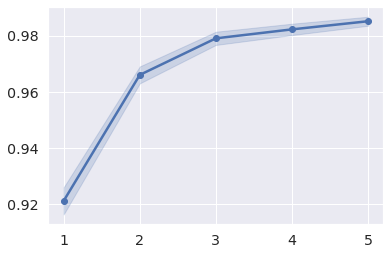

In [60]:
plot_CI(ms, 1-errs, c='C0',fmt='o-')

In [89]:
sns.set_style('ticks')

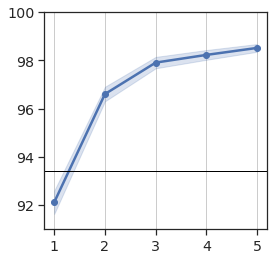

In [96]:
fig, ax = plt.subplots(figsize=(4,4))
plot_CI(ms, 100*(1-errs), c='C0',fmt='o-')
plt.axhline(100*(1-np.mean(zse[~mask])),c='black', linewidth=1)
plt.ylim([91,100])
ax.yaxis.grid(False)
ax.xaxis.grid(True)
# plt.savefig('images/zero_vs_fewshot.pdf')
# sns.despine();

## Distance to centroid

In [65]:
ys.shape

(988, 2048)

In [68]:
ymat = (ys[None] - ys[:,None])

In [69]:
x0mat = centers[None] - centers[:,None]

In [72]:
ymat /= np.linalg.norm(ymat,axis=-1,keepdims=True)

In [73]:
x0mat /= np.linalg.norm(x0mat,axis=-1,keepdims=True)

In [76]:
(centers[0]@ys[0])/np.linalg.norm(ys[0])/np.linalg.norm(centers[0])

DeviceArray(0.81176335, dtype=float32)

In [77]:
x0mat.shape

(988, 988, 2048)

In [78]:
ymat.shape

(988, 988, 2048)

(array([2.04000e+02, 9.19400e+03, 8.37620e+04, 2.39666e+05, 3.07438e+05,
        2.08552e+05, 8.72420e+04, 3.15680e+04, 7.24400e+03, 2.86000e+02]),
 array([0.63979983, 0.7555327 , 0.87126553, 0.98699844, 1.1027312 ,
        1.2184641 , 1.334197  , 1.4499298 , 1.5656627 , 1.6813955 ,
        1.7971284 ], dtype=float32),
 <a list of 10 Patch objects>)

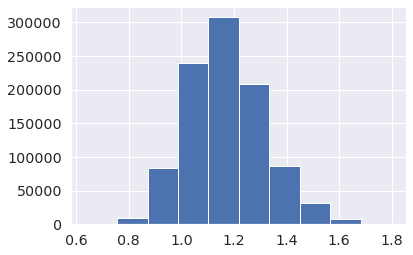

In [82]:
plt.hist(np.arccos((ymat*x0mat).sum(-1).ravel()))

In [67]:
centers.shape

(988, 2048)

In [144]:
# Average distance to test example of zero-shot prototypes, and m-shot prototypes

N = 2048
dists = []
one_dists = {}
ms = [1,2,3,4,5]
for m in ms:
    one_dists[m]=[]
for a in tqdm(range(len(wvs))):
    manifold = manifolds[embedding_idx[a]]
    y = map_procrustes(wvs[a],ax,ay,bx,by,O)
    dists.append(((y - manifold)**2).sum(-1))
    
    P = len(manifold)//2*2
    for m in ms:
        P1 = int(P/(1+1/m))//m*m
        P2 = int(P/(1+m))
        i1,i2,_ = np.split(np.random.permutation(len(manifold)),(P1,P1+P2))
        M = manifold[i1].reshape(m,-1,N).mean(0)
        one_dist = ((M - manifold[i2])**2).sum(-1)
        one_dists[m].append(one_dist)
dists = np.hstack(dists)

In [145]:
for m in ms:
    one_dists[m] = np.hstack(one_dists[m])

(0, 1000)

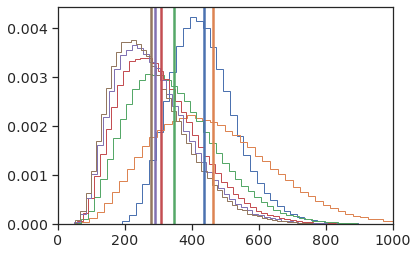

In [127]:
plt.hist(dists, bins=100, histtype='step', density=True);
plt.axvline(np.mean(dists))
for m in ms:
    plt.hist(one_dists[m], bins=100, histtype='step', density=True);
    plt.axvline(np.mean(one_dists[m]),c='C{}'.format(m))
plt.xlim([0,1000])

In [146]:
fewshot_means = []
for m in ms:
    fewshot_means.append(np.mean(one_dists[m]))

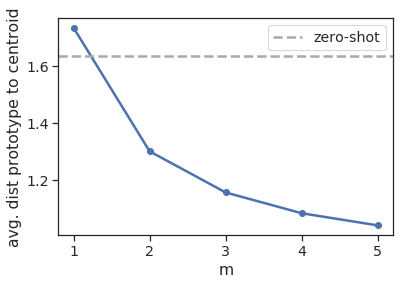

In [129]:
from scipy.spatial.distance import pdist
x0dist = pdist(centers)**2
plt.plot(ms,fewshot_means/x0dist.mean(),'o-')
plt.axhline(np.mean(dists)/x0dist.mean(),c='darkgrey',linestyle='dashed',label='zero-shot')
plt.xlabel('m')
plt.ylabel('avg. dist prototype to centroid');
plt.legend();

In [ ]:
dists = []
for a in tqdm(range(len(wvs))):
    manifold = manifolds[embedding_idx[a]]
    y = map_procrustes(wvs[a],ax,ay,bx,by,O)
    dists.append(((y - manifold)**2).sum(-1))
dists = np.hstack(dists)

In [229]:
ys = []
for a in tqdm(range(len(wvs))):
    y = map_procrustes(wvs[a],ax,ay,bx,by,O)
    ys.append(y)
ys = np.stack(ys)

## Signal-noise overlaps
How much do language embeddings overlap with the manifold subspace?

In [98]:
root = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'
model = 'resnet50'
save_dir = os.path.join(root, model+'/')
# manifolds = np.load(save_dir + 'manifolds.npy',allow_pickle=True)

In [99]:
Rs = np.load(save_dir + 'Rs.npy')
Us = np.load(save_dir + 'Us.npy')

In [ ]:
K = len(wvs)
signal = []
css = []
for a in tqdm(range(K)):
    for b in range(K):
        dxy = -((ys[a] - centers[a])**2).sum() + ((ys[b] - centers[a])**2).sum()
        signal.append(dxy / (Rs[a]**2).mean())
        
        costheta = Us[a]@(ys[a] - ys[b])
        cs = (Rs[a]**2 * costheta**2).mean() / (Rs[a]**2).mean()**2
        css.append(cs)
css = np.stack(css).reshape(K,K)
signal = np.stack(signal).reshape(K,K)

In [123]:
z = Us[embedding_idx[a]]@(ya-yb) / 
R = Rs[embedding_idx[a]]
((z*R)**2).sum() / (R**2).sum()

0.9894820815615673

In [101]:
import numpy as np

In [137]:
# Average distance to centroid of zero-shot prototypes, and m-shot prototypes
N = 2048
signal_zeroshot = []
da_zeroshot = []
db_zeroshot = []
noise_zeroshot = []
signal_fewshot = {}
da_fewshot = {}
db_fewshot = {}
noise_fewshot = {}
one_dists_b = {}
ms = [1,2,3,4,5]
for m in ms:
    signal_fewshot[m]=[]
    da_fewshot[m] = []
    db_fewshot[m] = []
    noise_fewshot[m]=[]
for _ in tqdm(range(100)):
    a,b = np.random.choice(len(embedding_idx),2,replace=False)
    manifold_a = manifolds[a]
    manifold_b = manifolds[b]
    ya = map_procrustes(wvs[a],ax,ay,bx,by,O)
    yb = map_procrustes(wvs[b],ax,ay,bx,by,O)
    
    R = Rs[embedding_idx[a]]
    dxa = ((ya - manifold_a.mean(0))**2).sum() / (R**2).mean()
    dxb = ((yb - manifold_a.mean(0))**2).sum() / (R**2).mean()
    da_zeroshot.append(dxa)
    db_zeroshot.append(dxb)
    signal_zeroshot.append(-dxa + dxb)
    
    U = Us[embedding_idx[a]]
    costheta = U@(ya - yb)
    cs = (R**2 * costheta**2).mean() / (R**2).mean()**2
    noise_zeroshot.append(cs)
    
    P = len(manifold_a)//2*2
    for m in ms:
        P1 = int(P/(1+1/m))//m*m
        P2 = int(P/(1+m))
        i1,i2,_ = np.split(np.random.permutation(len(manifold_a)),(P1,P1+P2))
        Ma = manifold_a[i1].reshape(m,-1,N).mean(0)
        Mb = manifold_b[i1].reshape(m,-1,N).mean(0)
        costheta = U@(Ma-Mb).T
        one_cs = (R[:,None]**2 * costheta**2).mean(0) / (R**2).mean()**2
        noise_fewshot[m].append(one_cs)
        
        one_dist_a = ((Ma - manifold_a.mean(0))**2).sum(-1) / (R**2).mean()
        da_fewshot[m].append(one_dist_a)
        one_dist_b = ((Mb - manifold_a.mean(0))**2).sum(-1) / (R**2).mean()
        db_fewshot[m].append(one_dist_b)
        signal_fewshot[m].append(-one_dist_a + one_dist_b)

In [139]:
for m in ms:
    da_fewshot[m] = np.hstack(da_fewshot[m])
    db_fewshot[m] = np.hstack(db_fewshot[m])
    signal_fewshot[m] = np.hstack(signal_fewshot[m])
    noise_fewshot[m] = np.hstack(noise_fewshot[m])

In [150]:
signal_fewshot[1].shape

(25000,)

In [151]:
signal_fewshot[2].shape

(16600,)

In [152]:
stats.sem(signal_fewshot[2])

0.005632160905707006

In [153]:
fewshot_means_a = []
fewshot_means_b = []
fewshot_means_signal = []
fewshot_means_noise = []
fewshot_sem_signal = []
fewshot_sem_noise = []
fewshot_stds_a = []
for m in ms:
    fewshot_means_a.append(np.mean(da_fewshot[m]))
    fewshot_means_b.append(np.mean(db_fewshot[m]))
    fewshot_means_signal.append(np.mean(signal_fewshot[m]))
    fewshot_means_noise.append(np.mean(noise_fewshot[m]))
    fewshot_sem_signal.append(stats.sem(signal_fewshot[m]))
    fewshot_sem_noise.append(stats.sem(noise_fewshot[m]))
fewshot_means_a = np.stack(fewshot_means_a)
fewshot_means_b = np.stack(fewshot_means_b)
fewshot_means_signal = np.stack(fewshot_means_signal)
fewshot_means_noise = np.stack(fewshot_means_noise)
fewshot_sem_signal = np.stack(fewshot_sem_signal)
fewshot_sem_noise = np.stack(fewshot_sem_noise)
# fewshot_stds_a = np.stack(fewshot_stds_a)

Text(0.5, 0, 'm')

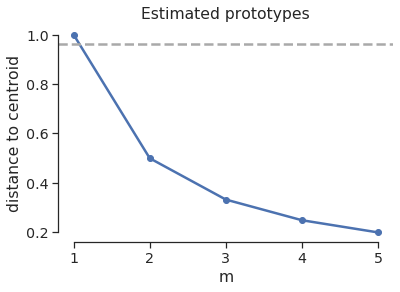

In [154]:
plt.title('Estimated prototypes')
plt.ylabel('distance to centroid')
plt.plot(ms, fewshot_means_a, 'o-')
plt.axhline(np.mean(da_zeroshot), linestyle='dashed', c='darkgrey')
sns.despine(trim=True)
plt.xlabel('m')

Text(0.5, 0, 'm')

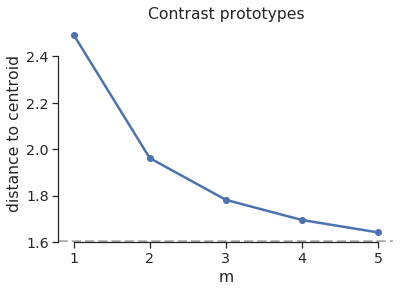

In [142]:
plt.title('Contrast prototypes')
plt.ylabel('distance to centroid')
plt.plot(ms, fewshot_means_b, 'o-')
plt.axhline(np.mean(db_zeroshot), linestyle='dashed', c='darkgrey')
sns.despine(trim=True)
plt.xlabel('m')

In [158]:
fewshot_sem_signal

array([0.00618028, 0.00563216, 0.00592043, 0.00637523, 0.00685249])

In [169]:
sns.set_style('ticks')

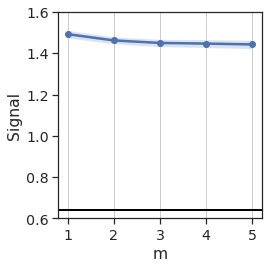

In [184]:
fig, ax = plt.subplots(figsize=(4,4))
plt.ylabel('Signal')
plt.plot(ms, fewshot_means_signal, 'o-')
plt.fill_between(ms, fewshot_means_signal+fewshot_sem_signal*3,
                fewshot_means_signal-fewshot_sem_signal*3,alpha=0.2)
plt.axhline(np.mean(signal_zeroshot), c='black', linewidth=2)
plt.ylim([0.6,1.6])
plt.xticks([1,2,3,4,5])
ax.yaxis.grid(False)
ax.xaxis.grid(True)
plt.xlabel('m')
plt.tight_layout()
plt.savefig('images/zeroshot_vs_fewshot_signal.pdf')

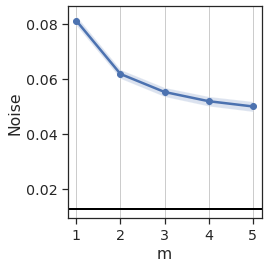

In [185]:
fig, ax = plt.subplots(figsize=(4,4))
plt.ylabel('Noise')
plt.plot(ms, fewshot_means_noise, 'o-')
plt.fill_between(ms, fewshot_means_noise+fewshot_sem_noise*5,
                fewshot_means_noise-fewshot_sem_noise*5,alpha=0.2)
plt.axhline(np.mean(noise_zeroshot), c='black', linewidth=2)
# plt.ylim([0.6,1.6])
ax.yaxis.grid(False)
plt.xticks([1,2,3,4,5])
ax.xaxis.grid(True)
plt.xlabel('m')
plt.tight_layout()
plt.savefig('images/zeroshot_vs_fewshot_noise.pdf')

In [145]:
SNR_fewshot = fewshot_means_signal/2 / np.sqrt(fewshot_means_noise)
SNR_zeroshot = np.mean(signal_zeroshot)/2 / np.sqrt(np.mean(noise_zeroshot))

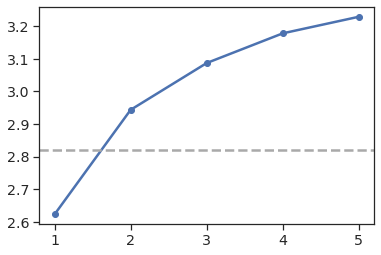

In [146]:
plt.plot(ms, SNR_fewshot, 'o-')
plt.axhline(SNR_zeroshot, c='darkgrey', linestyle='dashed')

In [63]:
sns.set_style('ticks')

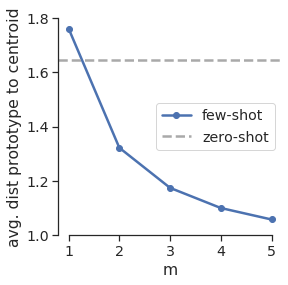

In [88]:
from scipy.spatial.distance import pdist

plt.figure(figsize=(4,4))
x0dist = pdist(centers)**2
plt.plot(ms,fewshot_means_a/x0dist.mean(),'o-', label='few-shot')
# plt.fill_between(ms,(fewshot_means_a+fewshot_stds_a)/x0dist.mean(),
#                  (fewshot_means_a-fewshot_stds_a)/x0dist.mean(),
#                 alpha=0.2)
plt.axhline(np.mean(dists_a)/x0dist.mean(),c='darkgrey',linestyle='dashed',label='zero-shot')
plt.xlabel('m')
plt.ylabel('avg. dist prototype to centroid');
plt.legend();
plt.ylim([1,1.8])
sns.despine(trim=True)
# plt.savefig('images/zero_vs_fewshot_dist_to_prototype.pdf')

In [56]:
# Average distance to centroid of zero-shot prototypes, and m-shot prototypes
N = 2048
dists_a = []
dists_b = []
cs = []
one_css = {}
one_dists_a = {}
one_dists_b = {}
ms = [1,2,3,4,5]
for m in ms:
    one_css[m]=[]
    one_dists_a[m]=[]
    one_dists_b[m]=[]
for _ in tqdm(range(100)):
    a,b = np.random.choice(len(embedding_idx),2,replace=False)
    manifold_a = manifolds[embedding_idx[a]][:500]
    manifold_b = manifolds[embedding_idx[b]][:500]
    ya = map_procrustes(wvs[a],ax,ay,bx,by,O)
    yb = map_procrustes(wvs[b],ax,ay,bx,by,O)
    z = Us[embedding_idx[a]]@(ya-yb)
    R = Rs[embedding_idx[a]]
    cs.append(((z*R)**2).sum() / (R**2).sum())
    
    dists_a.append(((ya - manifold_a)**2).sum(-1)/2 + ((yb - manifold_b)**2).sum(-1)/2)
    dists_b.append(((yb - manifold_a)**2).sum(-1)/2 + ((ya - manifold_b)**2).sum(-1)/2)
    
    P = len(manifold_a)//2*2
    for m in ms:
        P1 = int(P/(1+1/m))//m*m
        P2 = int(P/(1+m))
        i1,i2,_ = np.split(np.random.permutation(len(manifold_a)),(P1,P1+P2))
        Ma = manifold_a[i1].reshape(m,-1,N).mean(0)
        Mb = manifold_b[i1].reshape(m,-1,N).mean(0)
        z = Us[embedding_idx[a]]@(Ma-Mb).T
        one_cs = (z**2).sum(0)
        one_css[m].append(one_cs)
        
        one_dist_a = ((Ma - manifold_a[i2])**2).sum(-1)/2 + ((Mb - manifold_b[i2])**2).sum(-1)/2 
        one_dists_a[m].append(one_dist_a)
        one_dist_b = ((Mb - manifold_a[i2])**2).sum(-1)/2 + ((Ma - manifold_b[i2])**2).sum(-1)/2 
        one_dists_b[m].append(one_dist_b)
        
dists_a = np.hstack(dists_a)
dists_b = np.hstack(dists_b)
cs = np.hstack(cs)

In [57]:
for m in ms:
    one_dists_a[m] = np.hstack(one_dists_a[m])
    one_dists_b[m] = np.hstack(one_dists_b[m])
    one_css[m] = np.hstack(one_css[m])

In [83]:
fewshot_means_a = []
fewshot_means_b = []
fewshot_cs = []
fewshot_stds_a = []
for m in ms:
    fewshot_means_a.append(np.mean(one_dists_a[m]))
    fewshot_stds_a.append(np.std(one_dists_a[m]))
    fewshot_means_b.append(np.mean(one_dists_b[m]))
    fewshot_cs.append(np.mean(one_css[m]))
fewshot_means_a = np.stack(fewshot_means_a)
fewshot_stds_a = np.stack(fewshot_stds_a)

In [63]:
sns.set_style('ticks')

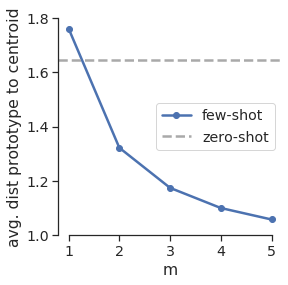

In [88]:
from scipy.spatial.distance import pdist

plt.figure(figsize=(4,4))
x0dist = pdist(centers)**2
plt.plot(ms,fewshot_means_a/x0dist.mean(),'o-', label='few-shot')
# plt.fill_between(ms,(fewshot_means_a+fewshot_stds_a)/x0dist.mean(),
#                  (fewshot_means_a-fewshot_stds_a)/x0dist.mean(),
#                 alpha=0.2)
plt.axhline(np.mean(dists_a)/x0dist.mean(),c='darkgrey',linestyle='dashed',label='zero-shot')
plt.xlabel('m')
plt.ylabel('avg. dist prototype to centroid');
plt.legend();
plt.ylim([1,1.8])
sns.despine(trim=True)
# plt.savefig('images/zero_vs_fewshot_dist_to_prototype.pdf')

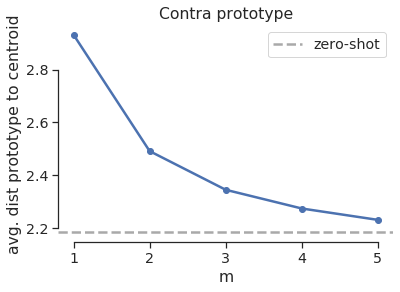

In [90]:
from scipy.spatial.distance import pdist
x0dist = pdist(centers)**2
plt.plot(ms,fewshot_means_b/x0dist.mean(),'o-')
plt.axhline(np.mean(dists_b)/x0dist.mean(),c='darkgrey',linestyle='dashed',label='zero-shot')
plt.xlabel('m')
plt.ylabel('avg. dist prototype to centroid');
plt.title('Contra prototype')
sns.despine(trim=True)
plt.legend();

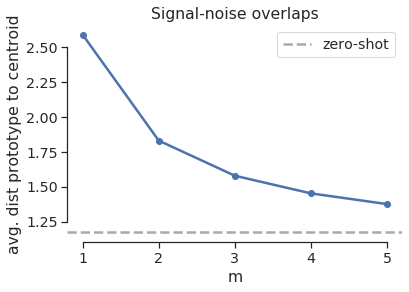

In [91]:
from scipy.spatial.distance import pdist
x0dist = pdist(centers)**2
plt.plot(ms,fewshot_cs/x0dist.mean(),'o-')
plt.axhline(np.mean(cs)/x0dist.mean(),c='darkgrey',linestyle='dashed',label='zero-shot')
plt.xlabel('m')
plt.ylabel('avg. dist prototype to centroid');
plt.title('Signal-noise overlaps')
sns.despine(trim=True)
plt.legend();

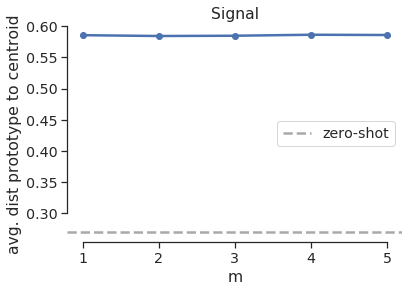

In [96]:
from scipy.spatial.distance import pdist
x0dist = pdist(centers)**2
signal_fewshot = (-fewshot_means_a + fewshot_means_b)/2/x0dist.mean()
plt.plot(ms,signal_fewshot,'o-')
signal_zeroshot = (-dists_a.mean()+dists_b.mean())/2/x0dist.mean()
plt.axhline(signal_zeroshot,c='darkgrey',linestyle='dashed',label='zero-shot')
plt.xlabel('m')
plt.ylabel('avg. dist prototype to centroid');
plt.title('Signal')
sns.despine(trim=True)
plt.legend();

In [103]:
SNR_fewshot = (-fewshot_means_a + fewshot_means_b)/2 / np.sqrt(fewshot_cs)
SNR_zeroshot = (-dists_a.mean()+dists_b.mean())/2 / np.sqrt(cs.mean())

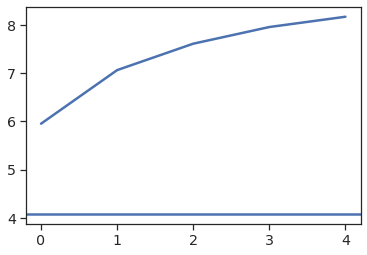

In [104]:
plt.plot(SNR_fewshot)
plt.axhline(SNR_zeroshot)

# Project manifolds

In [405]:
P = np.vstack([dx0,dy])

In [408]:
P /= np.linalg.norm(P,axis=-1,keepdims=True)

In [422]:
def plot_pair(a=None,b=None,wopt=None):
    if a==None:
        a,b = np.random.choice(988,2,replace=False)

    dx0 = manifolds[a].mean(0) - manifolds[b].mean(0)
    mu_x = (manifolds[a].mean(0) + manifolds[b].mean(0))/2
    ya = map_procrustes(wvs[a],ax,ay,bx,by,O)
    yb = map_procrustes(wvs[b],ax,ay,bx,by,O)
    dy = ya - yb
    mu_y = (ya+yb)/2
    P = np.vstack([dx0,dy])
#     P /= np.linalg.norm(P,axis=-1,keepdims=True)
    P,_ = np.linalg.qr(P.T)
    P = P.T
    
    Xa = P@manifolds[a].T
    yPa = P@ya

    Xb = P@manifolds[b].T
    yPb = P@yb

    plt.scatter(Xa[0],Xa[1], alpha=0.1, c='C0')
    plt.scatter(Xb[0],Xb[1], alpha=0.1, c='C2')
    plt.scatter(yPa[0],yPa[1],marker='*',s=100, c='C0',label=names[a].split(',')[0])
    plt.scatter(yPb[0],yPb[1],marker='*',s=100, c='C2',label=names[b].split(',')[0])

    Pdx0 = P@dx0
    Pmu_x = P@mu_x
    Pdy = P@dy
    Pmu_y = P@mu_y
        
    # xx = np.linspace(-1,1,100)
    # xx = np.linspace(Xa[0].min(),Xb[1].mean(),100)
    # plt.plot(xx, (xx-Pmu_x[0])*Pdx0[1]/Pdx0[0] + Pmu_x[1], c='C2', linestyle='dashed')
    # xx = np.linspace(-0.001,0.001,100)
    # plt.plot(xx, -(xx-Pmu_x[0])*Pdx0[0]/Pdx0[1] + Pmu_x[1], c='C2')

    xx = np.linspace(-15,15,100)
    # plt.plot(xx, (xx-Pmu_y[0])*Pdy[1]/Pdy[0] + Pmu_y[1], c='C3', linestyle='dashed')
    plt.plot(xx, -(xx-Pmu_y[0])*Pdy[0]/Pdy[1] + Pmu_y[1], c='black')
    if np.any(wopt!=None):
        Pwopt = P@wopt
        plt.plot(xx, -(xx-Pmu_y[0])*Pwopt[0]/Pwopt[1] + Pmu_y[1], c='darkgrey', label=r'$w^*$')
    plt.axis('equal')
#     plt.ylabel(r'$\Delta y_0$', fontsize=16)
#     plt.xlabel(r'$\Delta x_0$', fontsize=16)
#     plt.xlim([-0.7,0.7])
#     plt.ylim([-1/2,1/2])
    plt.legend(fontsize=12);
    
# plt.figure(figsize=(5,5))
# plot_pair(0,1)

In [235]:
from utils import make_square

zse = make_square(zse)

In [249]:
errs_5shot = np.load('/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/resnet50/errs_5shot.npy')
errs_5shot = errs_5shot[embedding_idx][:,embedding_idx]

In [423]:
errs_5shot_sym = (errs_5shot + errs_5shot.T)/2
zse_sym = (zse+zse.T)/2
ii = np.argsort((-errs_5shot_sym + zse_sym).ravel())
ii,jj = np.unravel_index(ii,(len(embedding_idx),len(embedding_idx)))

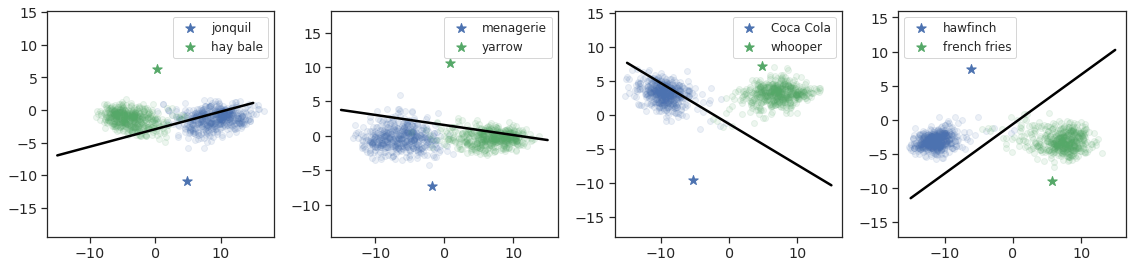

In [424]:
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plot_pair()
plt.tight_layout()
# plt.savefig('images/zero_shot_manifold_projections.pdf')

In [339]:
a,b = np.random.choice(len(embedding_idx),2,replace=False)
manifold_a = manifolds[a]
manifold_b = manifolds[b]
ya = map_procrustes(wvs[a],ax,ay,bx,by,O)
yb = map_procrustes(wvs[b],ax,ay,bx,by,O)
dy = ya-yb
dx0 = manifold_a.mean(0) - manifold_b.mean(0)
P = np.stack([dx0,dy])
P,_ = np.linalg.qr(P.T)

xa = manifold_a@P
xb = manifold_b@P

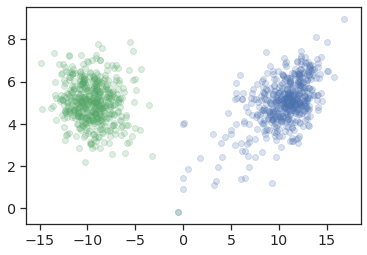

In [208]:
plt.scatter(xa[:,0],xa[:,1], c='C2', alpha=0.2)
plt.scatter(xb[:,0],xb[:,1], c='C0', alpha=0.2)

In [199]:
xa.shape

(500, 2)

In [197]:
P.shape

(2048, 2)

In [ ]:
# Average distance to centroid of zero-shot prototypes, and m-shot prototypes
for _ in tqdm(range(4)):
    a,b = np.random.choice(len(embedding_idx),2,replace=False)
    manifold_a = manifolds[a]
    manifold_b = manifolds[b]
    ya = map_procrustes(wvs[a],ax,ay,bx,by,O)
    yb = map_procrustes(wvs[b],ax,ay,bx,by,O)
    
    R = Rs[embedding_idx[a]]
    dxa = ((ya - manifold_a.mean(0))**2).sum() / (R**2).mean()
    dxb = ((yb - manifold_a.mean(0))**2).sum() / (R**2).mean()
    da_zeroshot.append(dxa)
    db_zeroshot.append(dxb)
    signal_zeroshot.append(-dxa + dxb)
    
    U = Us[embedding_idx[a]]
    costheta = U@(ya - yb)
    cs = (R**2 * costheta**2).mean() / (R**2).mean()**2
    noise_zeroshot.append(cs)
    
    P = len(manifold_a)//2*2
    for m in ms:
        P1 = int(P/(1+1/m))//m*m
        P2 = int(P/(1+m))
        i1,i2,_ = np.split(np.random.permutation(len(manifold_a)),(P1,P1+P2))
        Ma = manifold_a[i1].reshape(m,-1,N).mean(0)
        Mb = manifold_b[i1].reshape(m,-1,N).mean(0)
        costheta = U@(Ma-Mb).T
        one_cs = (R[:,None]**2 * costheta**2).mean(0) / (R**2).mean()**2
        noise_fewshot[m].append(one_cs)
        
        one_dist_a = ((Ma - manifold_a.mean(0))**2).sum(-1) / (R**2).mean()
        da_fewshot[m].append(one_dist_a)
        one_dist_b = ((Mb - manifold_a.mean(0))**2).sum(-1) / (R**2).mean()
        db_fewshot[m].append(one_dist_b)
        signal_fewshot[m].append(-one_dist_a + one_dist_b)